# 1. Introduction 

=======================================================================================================================

Name : Ardiansyah Putra Mahadka

Batch : BSD - 006 

This program is developed to analyze the behavior of credit card users and segment them to identify the risks that can be managed by the credit card issuer, in this case, the bank. The dataset processed is retrieved from the BigQuery public dataset.

=======================================================================================================================

## Conceptual Problems

1. Inersia mengukur jumlah jarak kuadrat dari titik data ke pusat cluster. Inersia berkurang seiring bertambahnya jumlah cluster. Untuk menemukan jumlah cluster yang optimal, kita mencari titik di mana penurunan inersia mulai melambat.

2. Elbow Method digunakan untuk mempertimbangkan dalam menentukan jumlah cluster optimal berdasarkan inersia model. Metode ini dilakukan dengan membuat plot grafik jumlah cluster dan inersia, lalu memilih titik di mana penurunan inersia melambat (titik siku). Pemilihan jumlah cluster bersifat subjektif menurut pembuat model dan tidak didasarkan pada nilai absolut untuk jumlah cluster yang optimal.

## Background

The analysis of credit card data is crucial for understanding customer behavior and improving financial management strategies. By segmenting credit card customers, we can identify different customer profiles, assess their credit risk, and tailor financial products and services to meet their specific needs. The goal is to gain insights into customer segments, identify high-risk customers, and develop strategies to mitigate potential losses while enhancing customer satisfaction and loyalty.

## Problem Statement (SMART)

The goal of this analysis is to identify and segment credit card customers based on their behavior and spending patterns to assess their credit risk. By analyzing a dataset's feature, as a Data Scientist, I be aiming to create distinct customer segments.

To achieve this, I will utilize clustering algorithms and risk assessment models to categorize customers into at least four distinct segments based on their financial behavior.

Accurately segmenting customers will allow the bank to develop targeted financial products and services, improve risk management, and enhance customer satisfaction and loyalty. This analysis and segmentation will be completed within 5 days, providing actionable insights and recommendations to the bank for implementation in the next quarterly financial review.

## Retrieving data from bigquery through google colab

```sql

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "ftds-hacktiv8-project-427407"
client = bigquery.Client(project=project_id)

df_ori = client.query('''
SELECT * 
FROM `ftds-hacktiv8-project.phase1_ftds_006_bsd.credit-card-information`
WHERE MOD(CUST_ID,2) = 0;
''').to_dataframe()

df_ori

```

# 2. Query SQL

```sql
SELECT * 
FROM `ftds-hacktiv8-project.phase1_ftds_006_bsd.credit-card-information`
WHERE MOD(CUST_ID,2) = 0;
```

# 3. Import Libraries

In [1]:
!pip install yellowbrick


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from feature_engine.outliers import Winsorizer
from phik import phik_matrix
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Import K-Means
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

# Saving Model
import pickle
import json


/Users/ardiansyahputra/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 4. Data Loading

- retrieve dataset from .csv file

In [3]:
df_ori = pd.read_csv('P1G6_Set_1_ardiansyah_putra.csv')

# check dimension of original dataset
df_ori.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [4]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

## Column explanation

| Column | Description | Datatype | Is Correct Datatype |
| :---------------------: | :---------------------------------: | :----------------------------: | :------------: |
| cust_id | Unique value of customer  | int64 | No | 
| balance | Amount left in customer's account to make purchase | float64 | Yes |
| balance_frequency | Calculation of many times the balance is updated each month over a given tenure period. | float64 | Yes |
| purchases | Amount of purchases mand from account | float64 | Yes |
| oneoff_purchases | Amount purchases in one-go | float64 | Yes |
| installment_purchases | Amount of purchases in installment | float64 | Yes |
| cash_advance | Cash in advance given by the user | float64 | Yes |
| puchases_frequency | Calculation of many times the purchases is made each month over a given tenure period | float64 | Yes |
| oneoff_purchases_frequency | Calculation of many times the oneoff purchases is made each month over a given tenure period  | float64 | Yes |
| cash_advance_frequency | Calculation of many times the cash advance is made each month over a given tenure | float64 | Yes |
| cash_advance_trx | number of cash advance transaction made | int64 | Yes|
| purchases_trx | number of purchase transactions made | int64 | Yes|
| credit_limit | limit of credit card user | float64 | Yes |
| payments | Amount of payment done by customer | float64 | Yes |
| minimum_payments | minimum amount that the customer must pay each month during the tenure period | float64 | Yes |
| prc_full_payment | percentage of full payment paid by customer  | float64 | Yes |
| tenure | tenure of credit card service | int64 | Yes |

### Statement

From the column explanation above, it shows that only the column 'cust_id' has an incorrect datatype, which is int64. It should be of datatype object because 'cust_id' is a label representing a customer based on a unique value, and its value is not used for aggregation.

In [5]:
df_ori

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0,2,1200.0,0.000000,NaN,0.000000,8
1,1902,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,8
2,2322,1.979916,0.125000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.000000,NaN,0.000000,8
3,3426,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,8
4,3976,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11


In [6]:
df_ori.corr()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,1.000000,-0.015013,0.000624,-0.025301,-0.021106,-0.022561,-0.005638,0.005467,0.005186,-0.004781,-0.010696,-0.020332,-0.011687,-0.011807,-0.019458,-0.023386,0.023323,0.025762
BALANCE,-0.015013,1.000000,0.324241,0.175823,0.161688,0.128466,0.474046,-0.078883,0.079834,-0.065844,0.432476,0.387724,0.149029,0.537455,0.330390,0.413726,-0.317107,0.072629
BALANCE_FREQUENCY,0.000624,0.324241,1.000000,0.132362,0.107377,0.122374,0.088934,0.233056,0.202280,0.179915,0.192755,0.145848,0.191577,0.103518,0.067668,0.137043,-0.124335,0.120648
PURCHASES,-0.025301,0.175823,0.132362,1.000000,0.923486,0.724340,-0.050633,0.380525,0.492828,0.307307,-0.123355,-0.072105,0.684602,0.353386,0.593112,0.065739,0.180779,0.085754
ONEOFF_PURCHASES,-0.021106,0.161688,0.107377,0.923486,1.000000,0.404456,-0.019092,0.262689,0.526764,0.129748,-0.080837,-0.043558,0.565555,0.315393,0.565442,0.030906,0.135833,0.059940
INSTALLMENTS_PURCHASES,-0.022561,0.128466,0.122374,0.724340,0.404456,1.000000,-0.086531,0.435225,0.228154,0.499645,-0.148909,-0.093739,0.615818,0.275624,0.397696,0.101100,0.186713,0.096866
CASH_ADVANCE,-0.005638,0.474046,0.088934,-0.050633,-0.019092,-0.086531,1.000000,-0.220685,-0.093486,-0.186029,0.596778,0.632769,-0.106601,0.304072,0.485555,0.137014,-0.139065,-0.074381
PURCHASES_FREQUENCY,0.005467,-0.078883,0.233056,0.380525,0.262689,0.435225,-0.220685,1.000000,0.500035,0.864683,-0.318036,-0.220966,0.575191,0.132824,0.098505,-0.011232,0.289544,0.071775
ONEOFF_PURCHASES_FREQUENCY,0.005186,0.079834,0.202280,0.492828,0.526764,0.228154,-0.093486,0.500035,1.000000,0.147048,-0.116720,-0.086527,0.560623,0.323652,0.234473,-0.023127,0.138853,0.071715
PURCHASES_INSTALLMENTS_FREQUENCY,-0.004781,-0.065844,0.179915,0.307307,0.129748,0.499645,-0.186029,0.864683,0.147048,1.000000,-0.277246,-0.186499,0.535580,0.071717,0.080316,0.014403,0.243412,0.091378


In [7]:
# checking dimensionality of dataset
df_ori.shape

(4475, 18)

In [8]:
# display first 10 data of dataset
df_ori.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,0.875000,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,0.125000,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,1.000000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,1.000000,1450.0,1450.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,397.090516,227.143184,0.0,8
5,4266,2237.238086,1.000000,120.0,120.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2500.0,343.102984,712.986387,0.0,8
6,4360,2730.843802,1.000000,2900.0,2900.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2900.0,0.000000,NaN,0.0,8
7,4680,424.994385,0.375000,1200.0,1200.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,57.266292,56.720210,0.0,8
8,5884,18.885677,0.375000,57.0,57.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
9,24,0.004816,0.545455,51.7,0.0,51.7,0.0,0.250,0.000,0.250,0.0,0,3,3000.0,33.249088,0.059481,0.0,12


In [9]:
# display last 10 data of dataset
df_ori.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,1588,538.768762,0.909091,226.95,129.58,97.37,452.009130,0.545455,0.090909,0.454545,0.272727,8,9,1200.0,946.649324,211.220001,0.000000,11
4466,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.000000,11
4467,2528,427.642111,0.888889,0.00,0.00,0.00,2563.705644,0.000000,0.000000,0.000000,0.888889,62,0,1200.0,2853.967334,146.976542,0.500000,9
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.000000,9
4469,2152,1420.727073,1.000000,0.00,0.00,0.00,311.804499,0.000000,0.000000,0.000000,0.900000,9,0,1500.0,506.765033,449.179818,0.000000,10
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11
4474,3564,1977.007090,1.000000,1032.04,226.90,805.14,4335.919227,0.909091,0.090909,0.818182,0.545455,21,17,4000.0,3056.424974,910.707525,0.090909,11


In [10]:
# check datatype on each column
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [11]:
# check statistics informations of dataset
df_ori.describe()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4474.000000,4475.000000,4317.000000,4475.000000,4475.000000
mean,4476.000000,1565.743939,0.877608,1003.158324,588.504849,415.025075,973.453671,0.490122,0.202614,0.364989,0.134156,3.196425,14.490503,4494.020175,1726.212274,854.429538,0.157206,11.516425
std,2583.931114,2091.205727,0.235604,2210.812899,1666.500287,927.360842,2133.464502,0.399874,0.298502,0.397336,0.199221,6.500169,24.156038,3668.535689,2961.258570,2306.411178,0.295869,1.347819
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000
25%,2239.000000,132.536353,0.888889,40.065000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,390.206371,169.814310,0.000000,12.000000
50%,4476.000000,874.905296,1.000000,362.480000,29.990000,89.450000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,831.048408,309.854995,0.000000,12.000000
75%,6713.000000,2058.519163,1.000000,1122.640000,580.320000,484.255000,1098.569962,0.916667,0.333333,0.750000,0.181818,4.000000,17.000000,6000.000000,1895.959003,830.395060,0.166667,12.000000
max,8950.000000,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,29282.109150,1.000000,1.000000,1.000000,1.166667,110.000000,358.000000,30000.000000,46930.598240,61031.618600,1.000000,12.000000


- checking missing value

In [12]:
df_ori.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

- checking duplicated data

In [13]:
df_ori.duplicated().sum()

0

 - duplicate the dataset to be the dataset that will be analyzed

In [14]:
# copy data
df = df_ori.copy(deep=True)
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0,2,1200.0,0.000000,NaN,0.000000,8
1,1902,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,8
2,2322,1.979916,0.125000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,0.000000,NaN,0.000000,8
3,3426,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,8
4,3976,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11


- change columns name into lowercase

In [15]:
df.columns = df.columns.str.lower()
df.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

# 5. Exploratory Data Analysis (EDA)

- convert value of frequency column into categorical data

In [16]:
df['balance_frequency'] = df['balance_frequency'].apply(lambda x: "Never" if x == 0 else("Not Frequently" if 0 < x < 0.5 else("Occasionally" if 0.5 < x < 0.8 else "Frequently")))
df['purchases_frequency'] = df['purchases_frequency'].apply(lambda x: "Never" if x == 0 else("Not Frequently" if 0 < x < 0.5 else("Occasionally" if 0.5 < x < 0.8 else "Frequently")))
df['oneoff_purchases_frequency'] = df['oneoff_purchases_frequency'].apply(lambda x: "Never" if x == 0 else("Not Frequently" if 0 < x < 0.5 else("Occasionally" if 0.5 < x < 0.8 else "Frequently")))
df['purchases_installments_frequency'] = df['purchases_installments_frequency'].apply(lambda x: "Never" if x == 0 else("Not Frequently" if 0 < x < 0.5 else("Occasionally" if 0.5 < x < 0.8 else "Frequently")))
df['cash_advance_frequency'] = df['cash_advance_frequency'].apply(lambda x: "Never" if x == 0 else("Not Frequently" if 0 < x < 0.5 else("Occasionally" if 0.5 < x < 0.8 else "Frequently")))

In [17]:
df.head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,788,16.581535,Not Frequently,200.0,0.0,200.0,0.0,Not Frequently,Never,Not Frequently,Never,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,Frequently,103.0,103.0,0.0,0.0,Not Frequently,Not Frequently,Never,Never,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,Not Frequently,80.0,80.0,0.0,0.0,Not Frequently,Not Frequently,Never,Never,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,Frequently,585.0,585.0,0.0,0.0,Not Frequently,Not Frequently,Never,Never,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,Frequently,1450.0,1450.0,0.0,0.0,Not Frequently,Not Frequently,Never,Never,0,1,1500.0,397.090516,227.143184,0.0,8


## Number of customers who actively use their credit card during their tenure period based on balance frequency

In [18]:
df_group_1 = df.groupby('balance_frequency')['cust_id'].count().reset_index().sort_values(ascending=True, by='cust_id')
df_group_1

,balance_frequency,cust_id
1,Never,37
3,Occasionally,408
2,Not Frequently,417
0,Frequently,3613


Text(0.5, 1.0, 'Number of customer who active use credit card in tenure period')

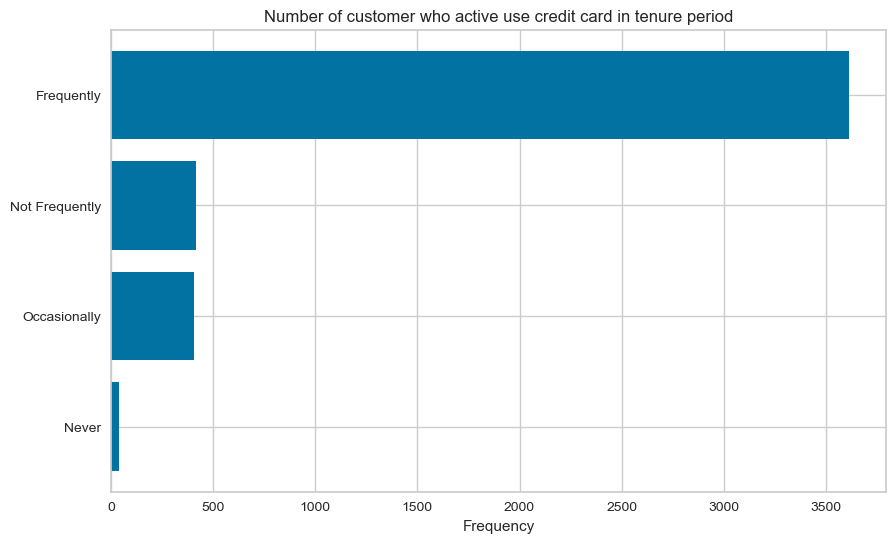

In [19]:
plt.figure(figsize=(10,6))
plt.barh(y='balance_frequency', data=df_group_1, width='cust_id')
plt.xlabel('Frequency')
plt.title('Number of customer who active use credit card in tenure period')

__Insight:__

- The majority of customers update their balance frequently (Frequently), with 3613 customers. This suggests that a significant portion of customers actively monitors their balance.
- The smallest group consists of 37 customers who never category update their balance. This group represents customers who either do not use their accounts actively or rely on other means to track their finances.

## Number of Credit Utilization (Risk Assessment)

In [20]:
diff_of_bal_lim = df['credit_limit'] - df['balance']
avg_diff_of_bal_lim = diff_of_bal_lim.mean()
avg_diff_of_bal_lim

2927.930383755476

In [21]:
df['risk'] = df['balance'].apply(lambda x: "High" if x < avg_diff_of_bal_lim else "Less")
df

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,risk
0,788,16.581535,Not Frequently,200.00,0.00,200.00,0.000000,Not Frequently,Never,Not Frequently,Never,0,2,1200.0,0.000000,NaN,0.000000,8,High
1,1902,943.584041,Frequently,103.00,103.00,0.00,0.000000,Not Frequently,Not Frequently,Never,Never,0,1,1000.0,215.325023,410.484825,0.000000,8,High
2,2322,1.979916,Not Frequently,80.00,80.00,0.00,0.000000,Not Frequently,Not Frequently,Never,Never,0,1,1500.0,0.000000,NaN,0.000000,8,High
3,3426,461.455720,Frequently,585.00,585.00,0.00,0.000000,Not Frequently,Not Frequently,Never,Never,0,1,1000.0,258.032630,151.696433,0.000000,8,High
4,3976,1053.594730,Frequently,1450.00,1450.00,0.00,0.000000,Not Frequently,Not Frequently,Never,Never,0,1,1500.0,397.090516,227.143184,0.000000,8,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,4630,1079.008102,Frequently,0.00,0.00,0.00,1259.571764,Never,Never,Never,Occasionally,9,0,1200.0,1379.635287,271.364415,0.090909,11,High
4471,8614,809.582978,Frequently,0.00,0.00,0.00,3819.672466,Never,Never,Never,Occasionally,7,0,4150.0,4372.148648,241.645387,0.090909,11,High
4472,4296,3386.490883,Frequently,560.98,427.22,133.76,2008.153534,Frequently,Occasionally,Not Frequently,Occasionally,9,20,10100.0,1039.000037,886.050237,0.000000,11,Less
4473,4476,4840.545574,Frequently,1595.93,1595.93,0.00,4359.325750,Not Frequently,Not Frequently,Never,Occasionally,17,25,6000.0,905.844846,2376.919568,0.090909,11,Less


In [22]:
df_group_2 = df.groupby('risk')['cust_id'].count().reset_index().rename(columns={'cust_id':'count'})
df_group_2

,risk,count
0,High,3727
1,Less,748


(-1.0999999934653508,
 1.0999998627723693,
 -1.0999999533611011,
 1.0999998560655546)

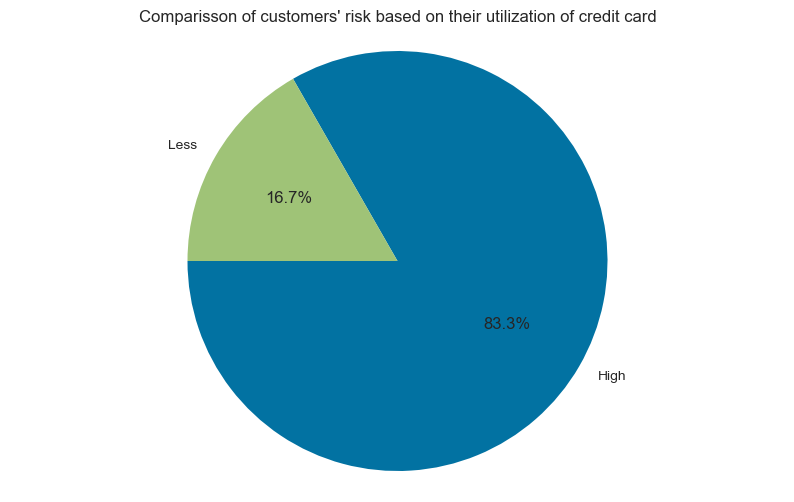

In [23]:
plt.figure(figsize=(10,6))
plt.pie(df_group_2['count'], labels=df_group_2['risk'], autopct='%1.1f%%', startangle=180)
plt.title('Comparisson of customers\' risk based on their utilization of credit card')
plt.axis('equal')


__Insight :__

Most of customer (3727 entries) have high credit risk, while a smaller number (748 entries) have lower credit risk

In [24]:
del df['risk']

## Distribution of customers' credit limit

In [25]:
avg_limit = df['credit_limit'].mean()
print(f'Average of customers\' credit limit: {avg_limit}')

Average of customers' credit limit: 4494.020174927581


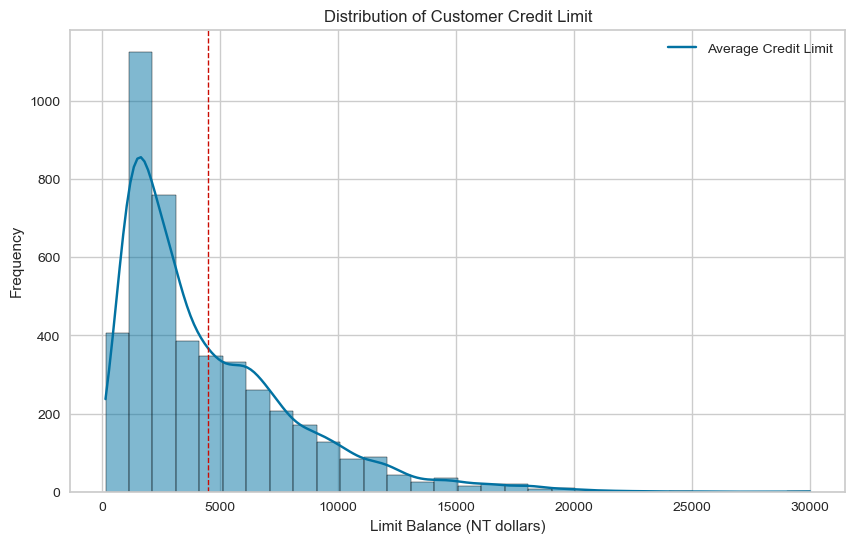

In [26]:
# Visualizing the distribution of limit balance with histogram 
plt.figure(figsize=(10, 6))
sns.histplot(df['credit_limit'], bins=30, kde=True)
plt.axvline(avg_limit, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('Limit Balance (NT dollars)')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Credit Limit')
plt.legend({'Average Credit Limit': avg_limit})
plt.show()

__Insight:__

- The distribution of customer credit limits is left-skewed with an average credit limit of approximately 4494.02. This indicates that the majority of customers have credit limits clustered towards the lower end of the range. Specifically, a significant portion of customers have credit limits up to 5000

- Since most customers have credit limits up to 5000, the bank's risk exposure is relatively contained within this range. This indicates a cautious credit assignment strategy where higher limits are likely reserved for customers with proven creditworthiness

## Assessing the condition of the bank as a credit card provider based on payments (amount number received by the bank) compared to purchases and cash advances (amount number issued by the bank)

In [27]:
# calculate amount of received and issued number
received_bank = df['payments'].sum()
issued_bank = df['purchases'].sum() + df['cash_advance'].sum()


print(f'amount of bank received: {received_bank}')
print(f'amount of bank issued: {issued_bank}')


amount of bank received: 7724799.92537
amount of bank issued: 8845338.677435


In [28]:
# convert into percenatge number
percentage_received = (received_bank / issued_bank) * 100
percentage_issued = 100 - percentage_received

print(f'percentage of bank received {percentage_received:.2f}%')
print(f'percentage of bank issued {percentage_issued:.2f}%')

percentage of bank received 87.33%
percentage of bank issued 12.67%


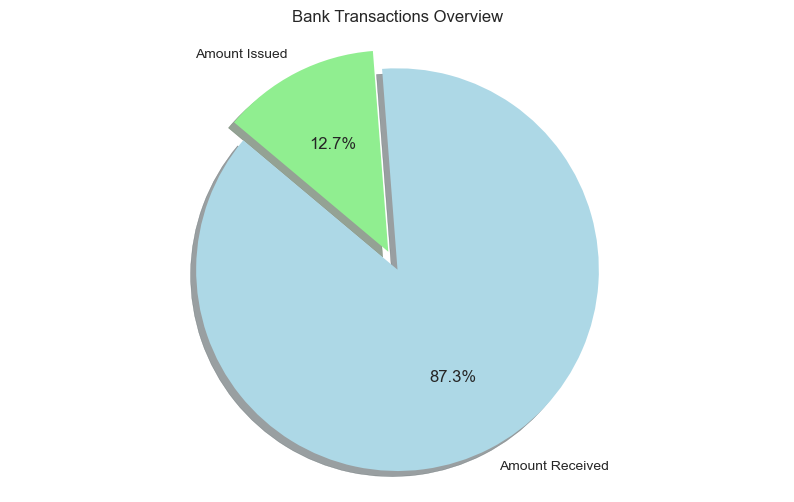

In [29]:
# Visualizing
labels = ['Amount Received', 'Amount Issued']
sizes = [percentage_received, percentage_issued]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  

plt.figure(figsize=(10, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Bank Transactions Overview')
plt.axis('equal') 
plt.show()

__Insights:__

- Percentage of Bank Received (87.33%) indicates that a significant majority of the bank's transactions involve receiving funds. This could suggest that the bank is mainlya engaged in activities such as monthly payments made by customers or other forms of income generation where funds are coming into the bank (such as interest, penalty etc)


## Distribution of customers' balance based on their tenure

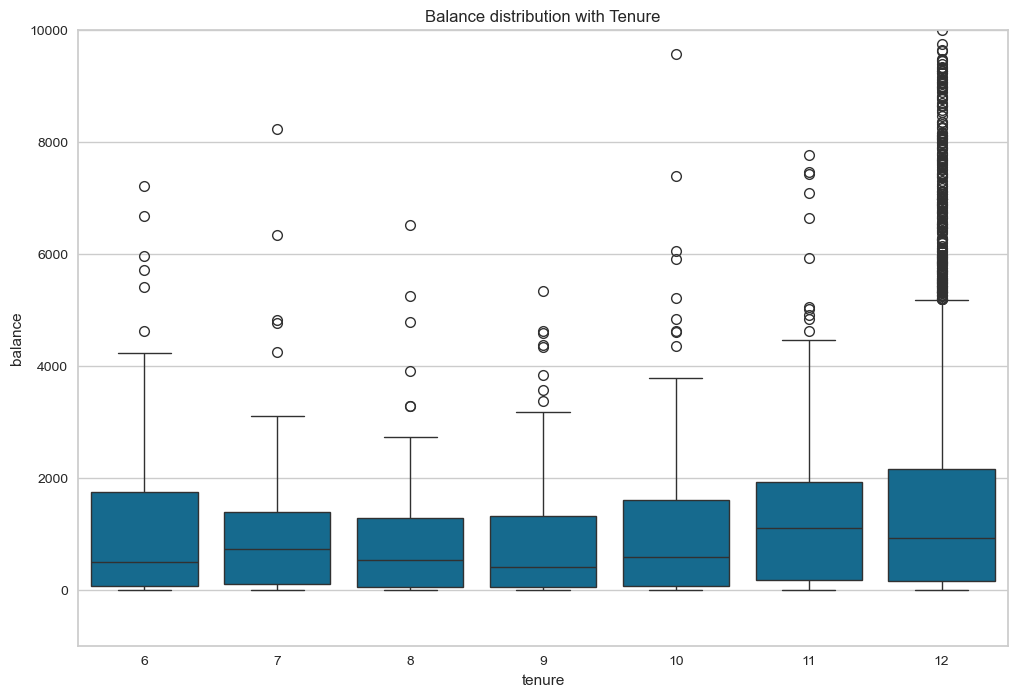

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="tenure", y="balance", data=df)
plt.ylim(-10**3, 10**4)
plt.title('Balance distribution with Tenure')
plt.show()

__Insight:__

There are some extreme value of balance in Tenure 12 month. It indicates that higher balances could signify customers with higher credit limits and potentially higher creditworthiness. Instead lower balances might indicate customers with more constrained financial capacity or credit limits.

# 6. Feature Engineering

In [31]:
df = df_ori.copy(deep=True)
df.columns = df.columns.str.lower()
df.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

## Handling Missing Value

In [32]:
df.isna().sum().sort_values(ascending=False)

minimum_payments                    158
credit_limit                          1
cust_id                               0
balance                               0
prc_full_payment                      0
payments                              0
purchases_trx                         0
cash_advance_trx                      0
cash_advance_frequency                0
purchases_installments_frequency      0
oneoff_purchases_frequency            0
purchases_frequency                   0
cash_advance                          0
installments_purchases                0
oneoff_purchases                      0
purchases                             0
balance_frequency                     0
tenure                                0
dtype: int64

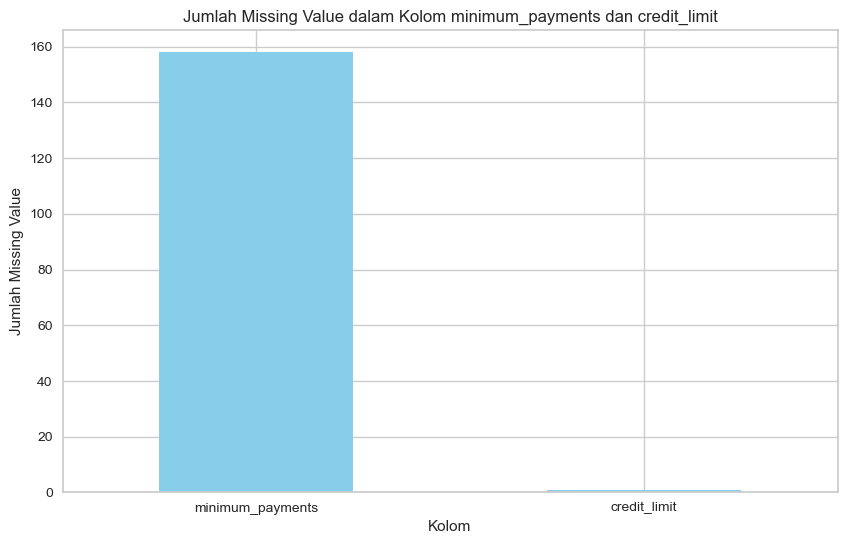

In [33]:
missing_count = df[['minimum_payments', 'credit_limit']].isnull().sum()

# Visualize the missing value
plt.figure(figsize=(10, 6))
missing_count.plot(kind='bar', color='skyblue')
plt.title('Jumlah Missing Value dalam Kolom minimum_payments dan credit_limit')
plt.xlabel('Kolom')
plt.ylabel('Jumlah Missing Value')
plt.xticks(rotation=0)
plt.show()

The results of the missing value check indicate that the 'minimum_payments' column has 158 missing values and the 'credit_limit' column has 1 missing value. Both columns meet the criteria for Missing Completly at Random (MCAR), meaning the data loss occurred randomly and is not related to other values or characteristics within the dataset, reducing the likelihood of bias in the data.

Determine to drop the missing values

In [34]:
df.dropna(inplace=True)

In [35]:
df.shape

(4316, 18)

## Handling Outlier

In [36]:
# define function to display outliers numbers on histogram and boxplot 
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

- checking the distribution of the selected feature which are having high unique value

In [37]:
columns_to_check = ['balance', 
                    'purchases',
                    'oneoff_purchases', 
                    'installments_purchases', 
                    'cash_advance', 
                    'purchases_frequency', 
                    'oneoff_purchases_frequency', 
                    'purchases_installments_frequency', 
                    'cash_advance_frequency',
                    'cash_advance_trx',
                    'purchases_trx', 
                    'credit_limit', 
                    'payments',
                    'minimum_payments',
                    'prc_full_payment']

# not including tenure column due the feature has few unique value

balance - Before Capping


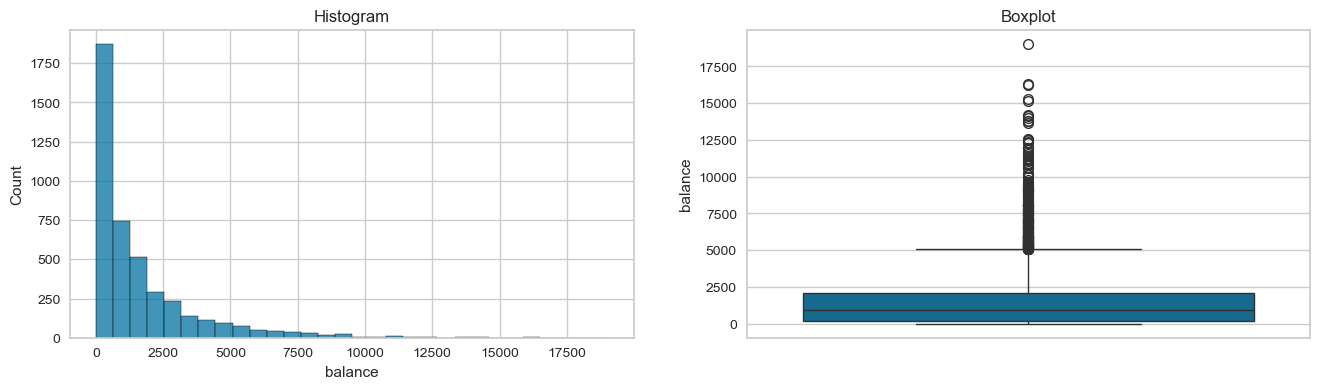

purchases - Before Capping


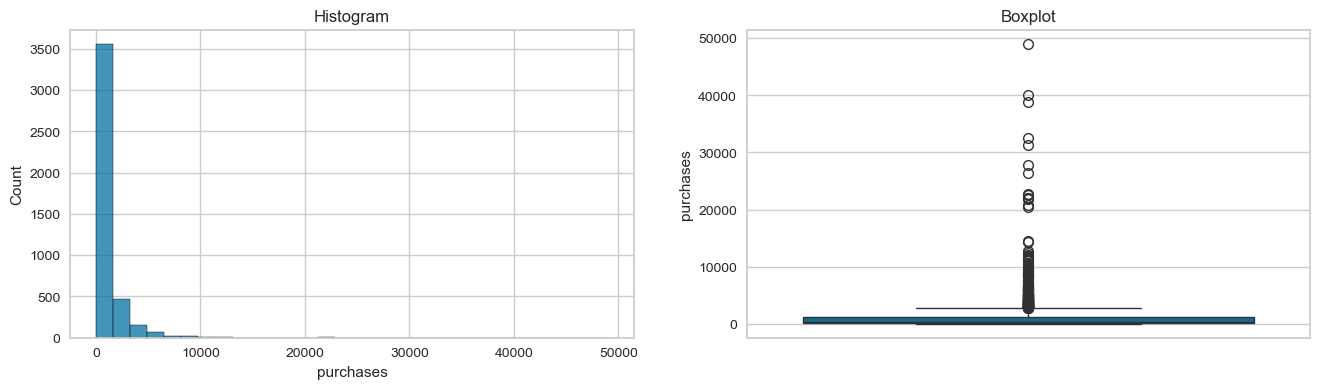

oneoff_purchases - Before Capping


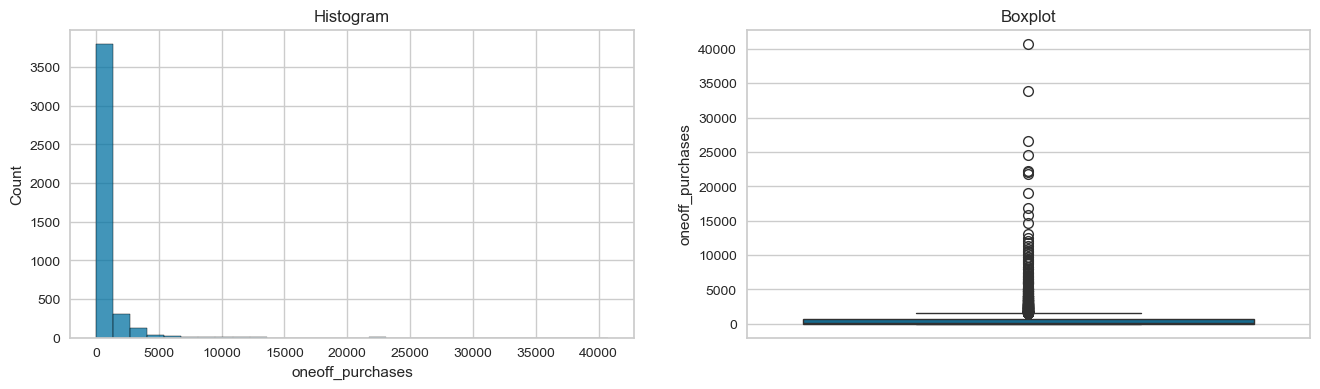

installments_purchases - Before Capping


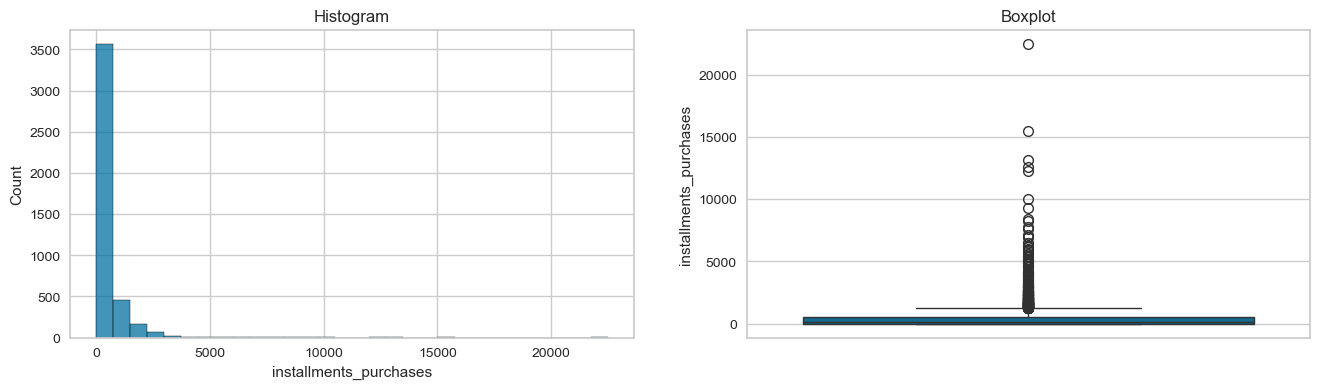

cash_advance - Before Capping


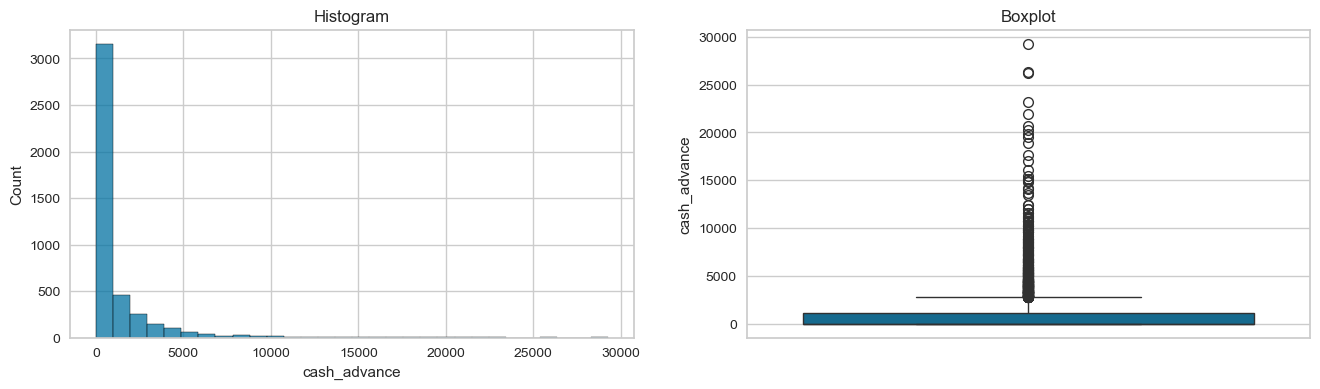

purchases_frequency - Before Capping


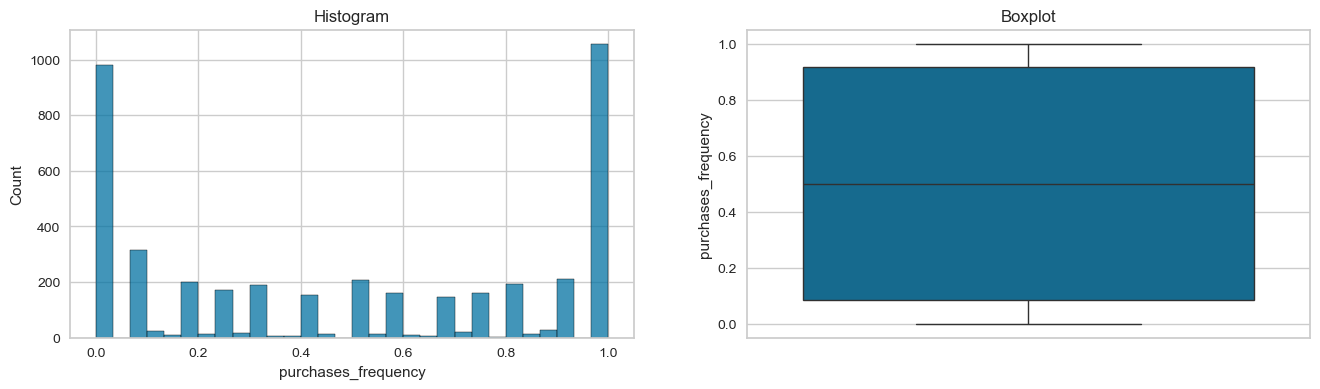

oneoff_purchases_frequency - Before Capping


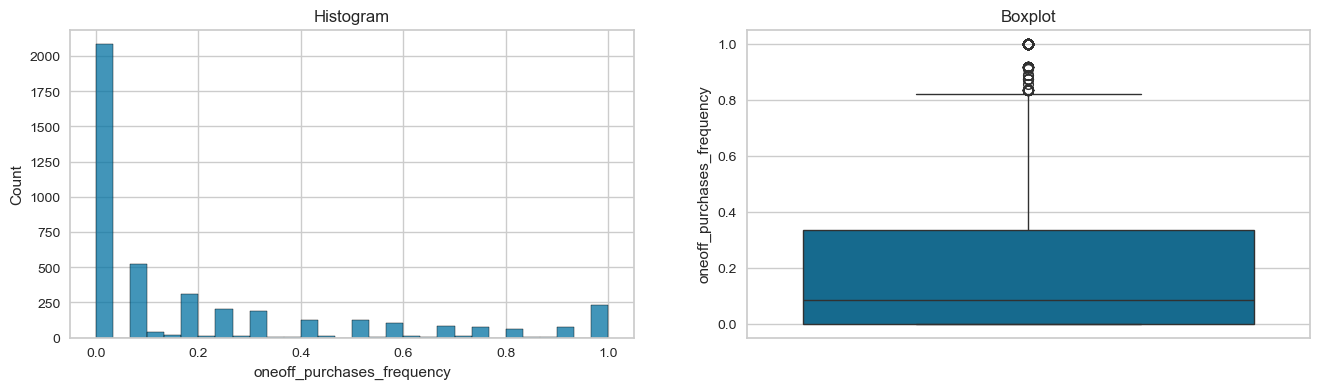

purchases_installments_frequency - Before Capping


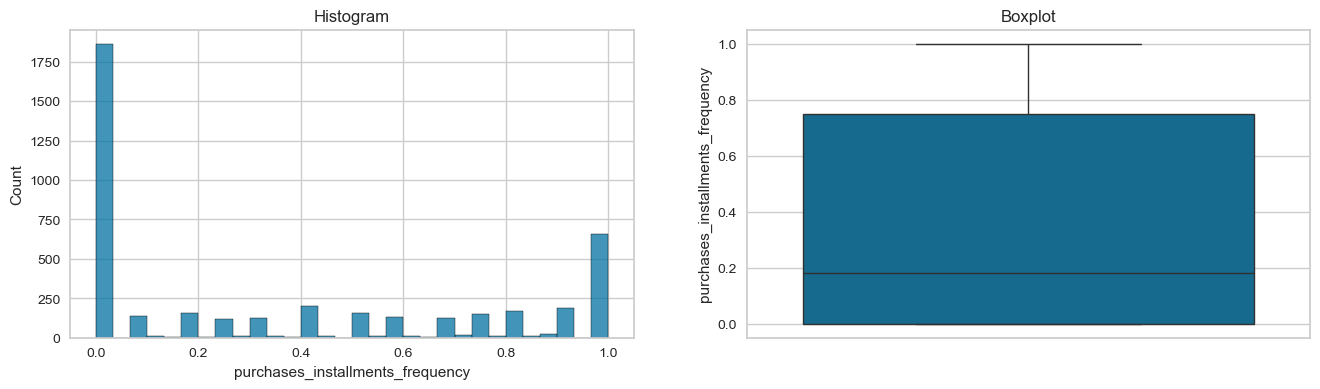

cash_advance_frequency - Before Capping


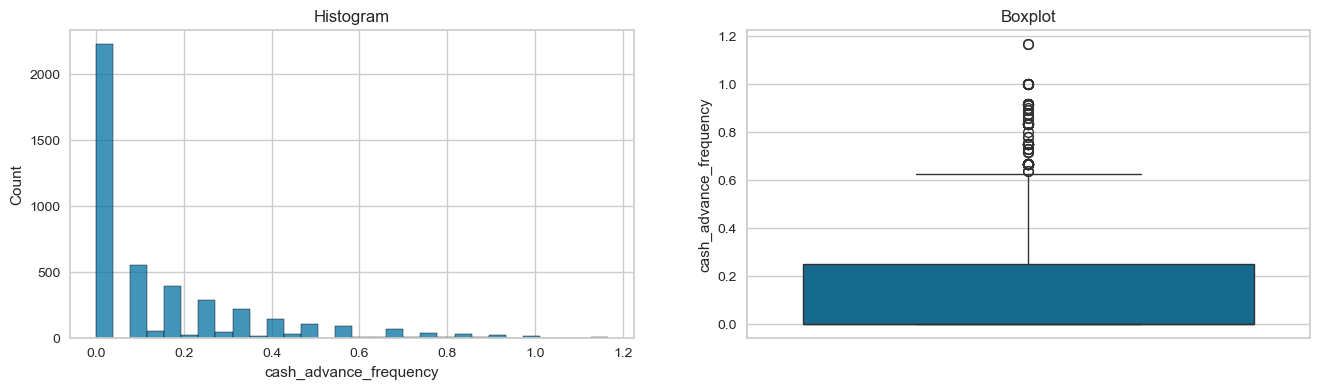

cash_advance_trx - Before Capping


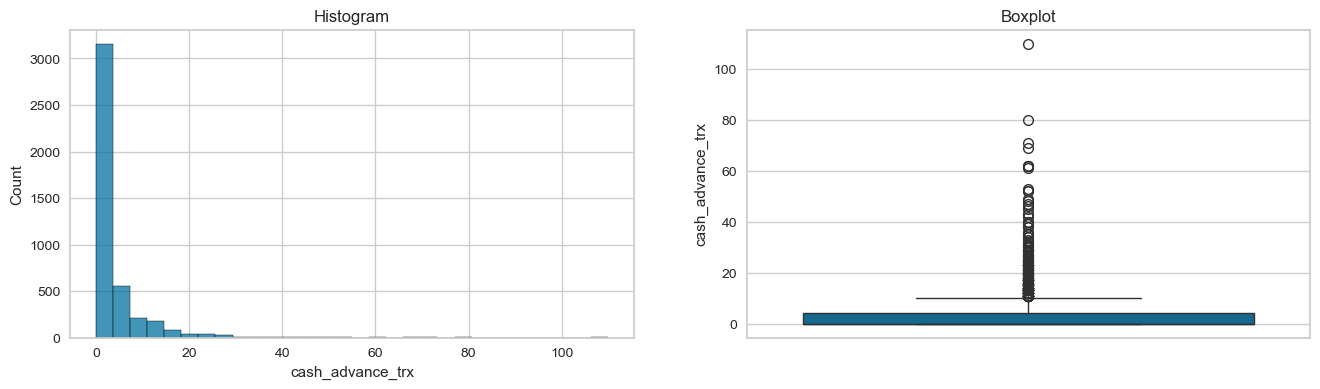

purchases_trx - Before Capping


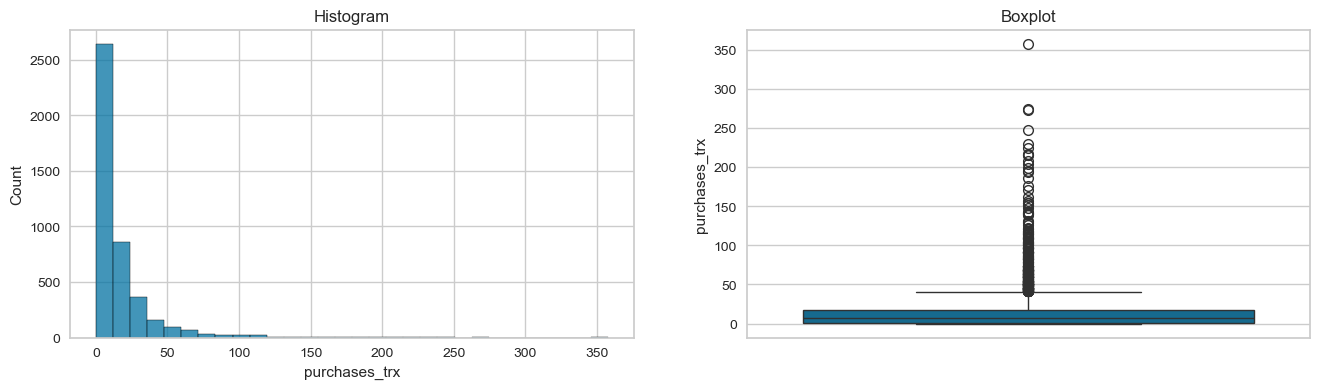

credit_limit - Before Capping


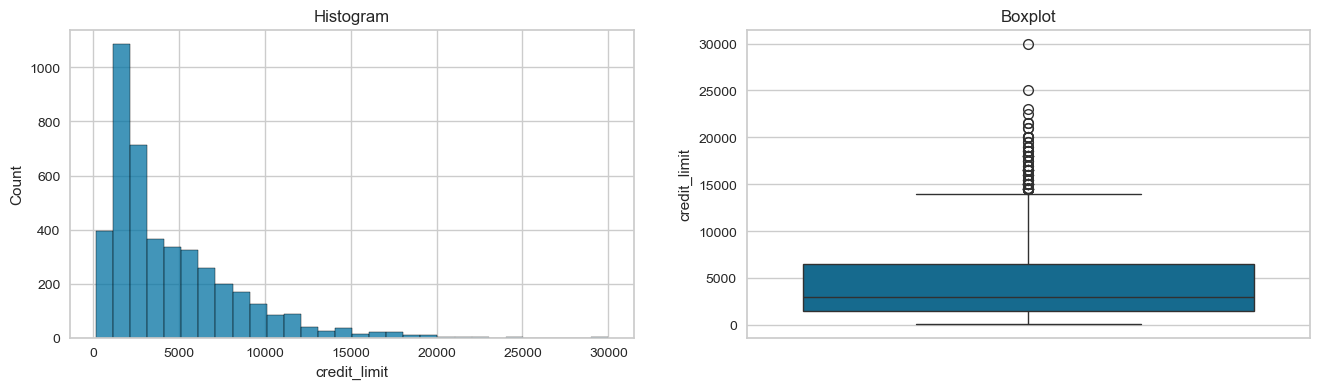

payments - Before Capping


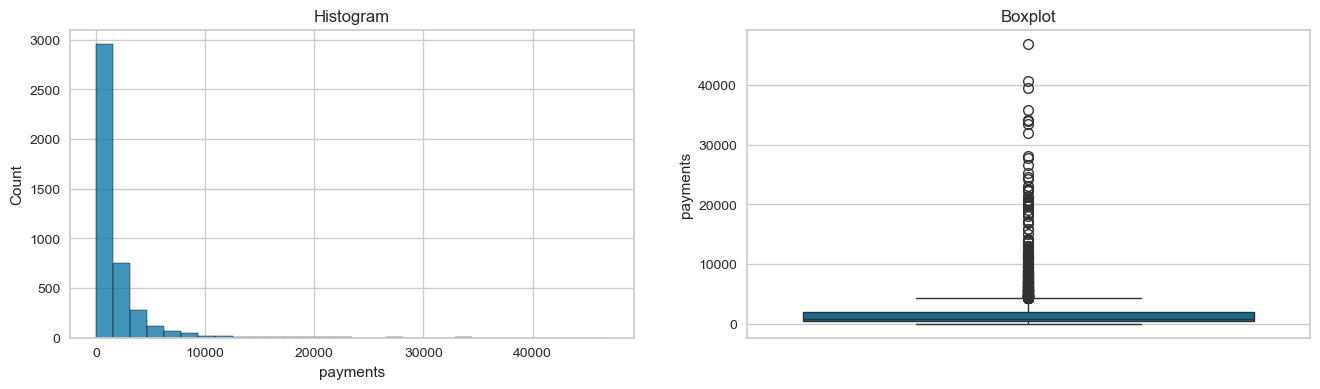

minimum_payments - Before Capping


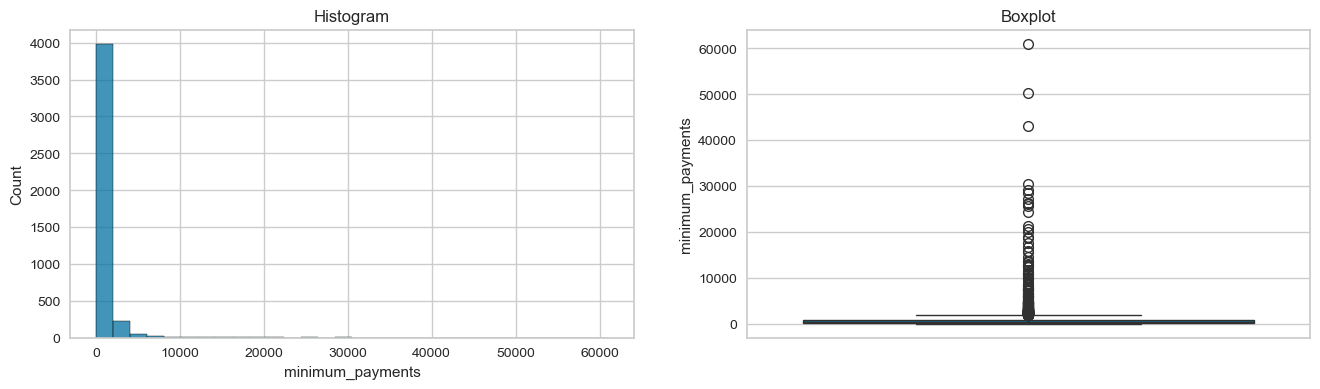

prc_full_payment - Before Capping


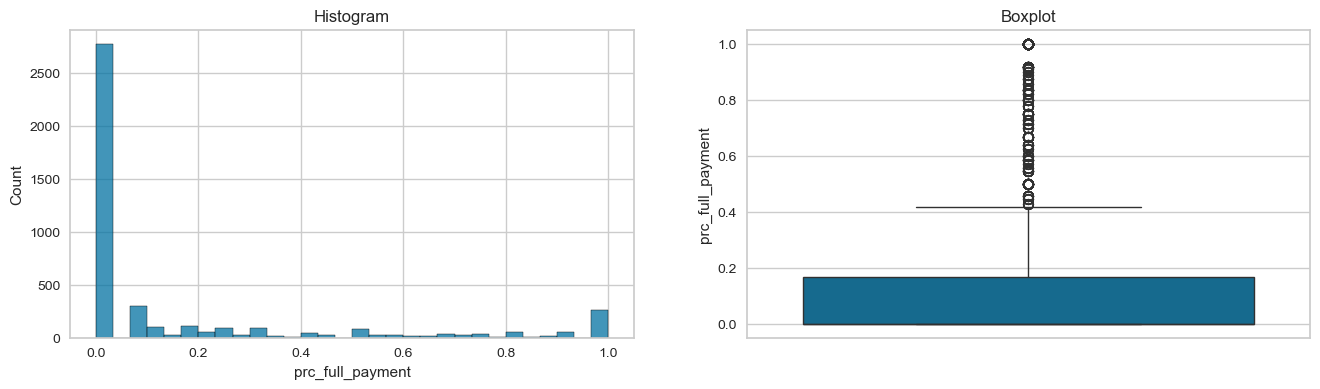

In [38]:
for column in columns_to_check:
    print(f'{column} - Before Capping')
    diagnostic_plots(df, column)

In [39]:
for column in columns_to_check:
    skewness = df[column].skew()
    print(f'Skewness value of {column}: {skewness}')

Skewness value of balance: 2.440901091038025
Skewness value of purchases: 8.902272454100581
Skewness value of oneoff_purchases: 10.045515316290516
Skewness value of installments_purchases: 8.030304885938177
Skewness value of cash_advance: 4.713174552567423
Skewness value of purchases_frequency: 0.035641946018049195
Skewness value of oneoff_purchases_frequency: 1.49450472491376
Skewness value of purchases_installments_frequency: 0.4865766900569389
Skewness value of cash_advance_frequency: 1.7888346981313274
Skewness value of cash_advance_trx: 4.722877319817404
Skewness value of purchases_trx: 4.429897311633816
Skewness value of credit_limit: 1.525378783156858
Skewness value of payments: 5.987444897467956
Skewness value of minimum_payments: 12.356757627194938
Skewness value of prc_full_payment: 1.8543999106579778


- Checking number of outliers on each feature

In [40]:
df_handled = df.copy(deep=True)

for column in columns_to_check:
    skewness = df[column].skew()
    if skewness > 1 or skewness < -1:
            q3 = df[column].quantile(0.75)
            q1 = df[column].quantile(0.25)
            iqr = q3 - q1 
            lower_bound = q1 - 3*iqr
            upper_bound = q3 + 3*iqr
    elif -0.5 <= skewness <= 0.5:
            lower_bound = df[column].mean() - 3 * df[column].std()
            upper_bound = df[column].mean() + 3 * df[column].std()
    else:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
    outliers = df[column].loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_percentage = len(outliers) / len(df) * 100
        
    print(f'Number of outliers in {column}: {len(outliers)}')
    print(f'Percentage of outliers: {outliers_percentage:.5f}%')
    
# Capping the value of the feature
    
    if outliers_percentage <= 5:
        if skewness > 1 or skewness < -1:
            winsorizered = Winsorizer(capping_method='iqr', tail='both', fold='auto', variables=[column])
            df_handled[column] = winsorizered.fit_transform(df[[column]])
        elif -0.5 <= skewness <= 0.5:
            winsorizered = Winsorizer(capping_method='gaussian', tail='both', fold='auto', variables=[column])
            df_handled[column] = winsorizered.fit_transform(df[[column]])
        else:
            winsorizered = Winsorizer(capping_method='iqr', tail='both', fold='auto', variables=[column])
            df_handled[column] = winsorizered.fit_transform(df[[column]])

Number of outliers in balance: 95
Percentage of outliers: 2.20111%
Number of outliers in purchases: 173
Percentage of outliers: 4.00834%
Number of outliers in oneoff_purchases: 257
Percentage of outliers: 5.95459%
Number of outliers in installments_purchases: 175
Percentage of outliers: 4.05468%
Number of outliers in cash_advance: 238
Percentage of outliers: 5.51437%
Number of outliers in purchases_frequency: 0
Percentage of outliers: 0.00000%
Number of outliers in oneoff_purchases_frequency: 0
Percentage of outliers: 0.00000%
Number of outliers in purchases_installments_frequency: 0
Percentage of outliers: 0.00000%
Number of outliers in cash_advance_frequency: 2
Percentage of outliers: 0.04634%
Number of outliers in cash_advance_trx: 178
Percentage of outliers: 4.12419%
Number of outliers in purchases_trx: 167
Percentage of outliers: 3.86932%
Number of outliers in credit_limit: 4
Percentage of outliers: 0.09268%
Number of outliers in payments: 190
Percentage of outliers: 4.40222%
Numb

balance After Capping


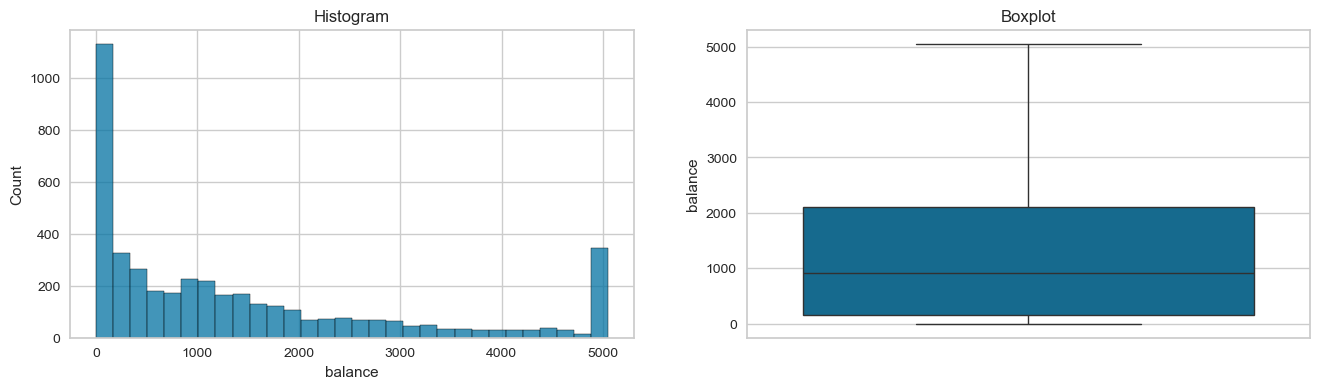

purchases After Capping


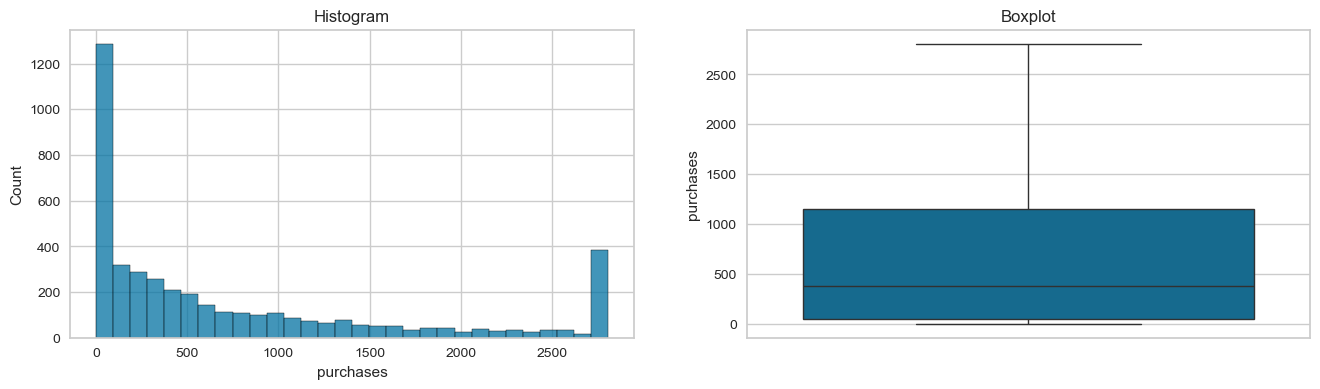

oneoff_purchases After Capping


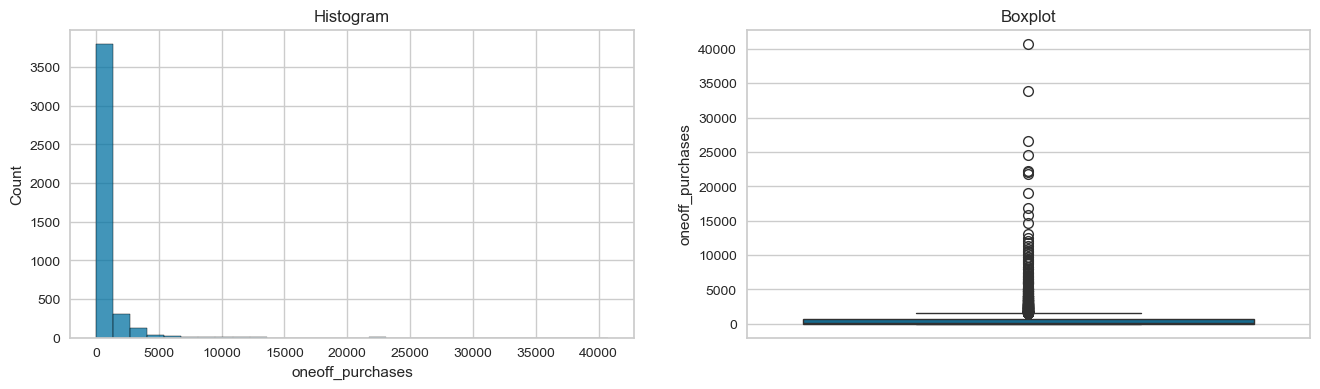

installments_purchases After Capping


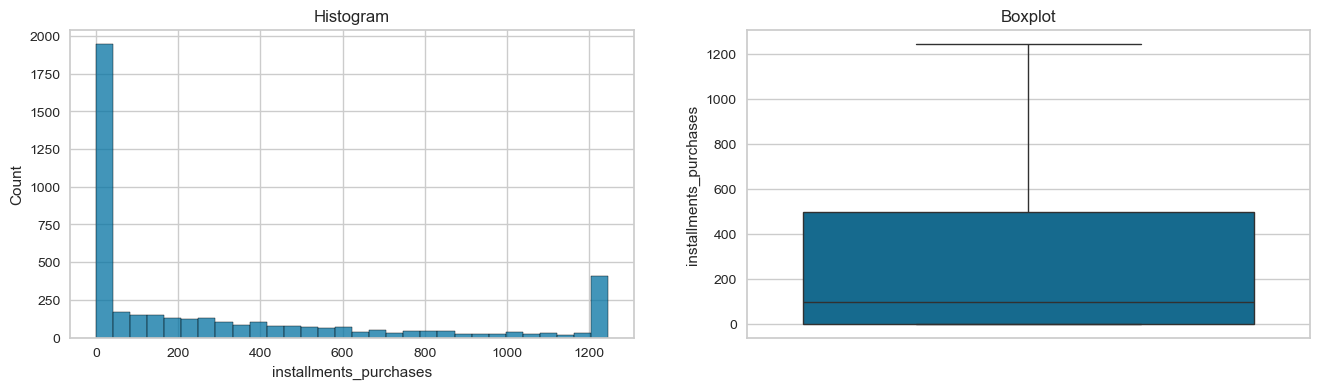

cash_advance After Capping


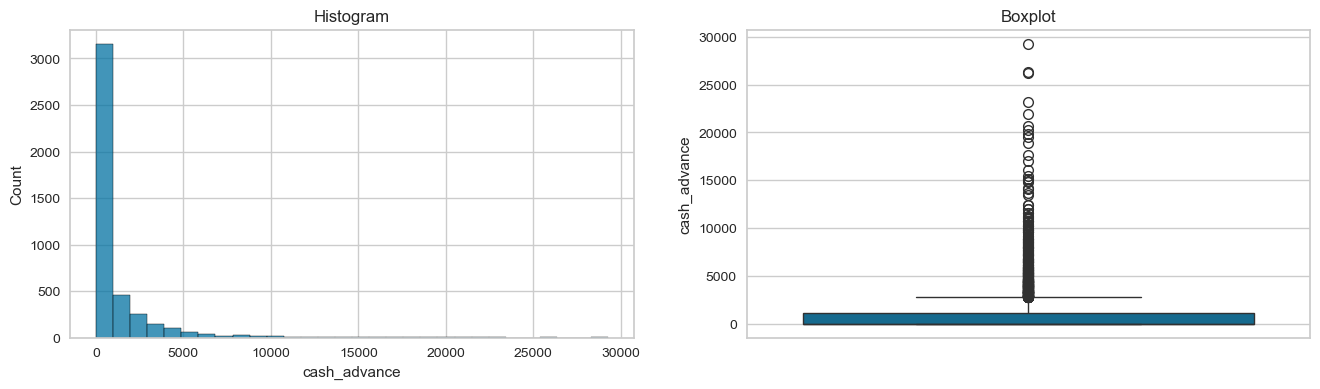

purchases_frequency After Capping


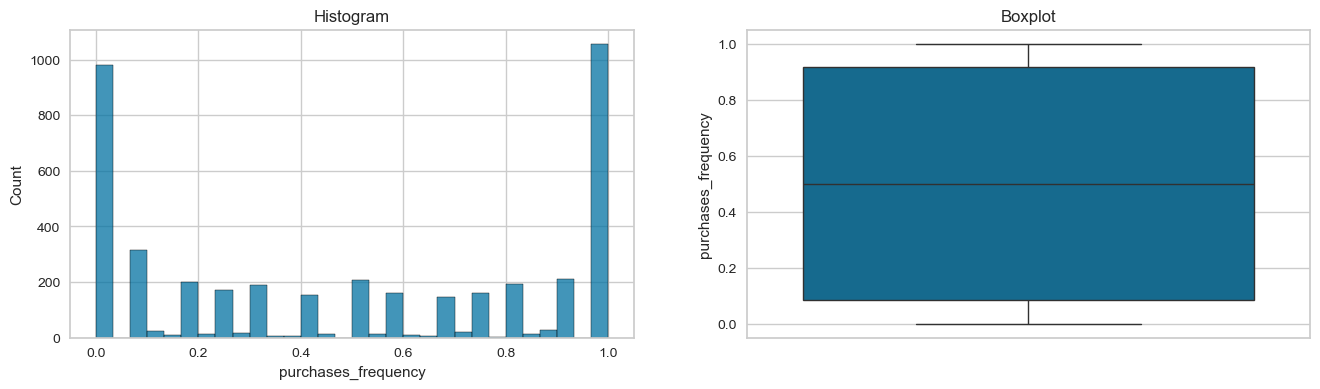

oneoff_purchases_frequency After Capping


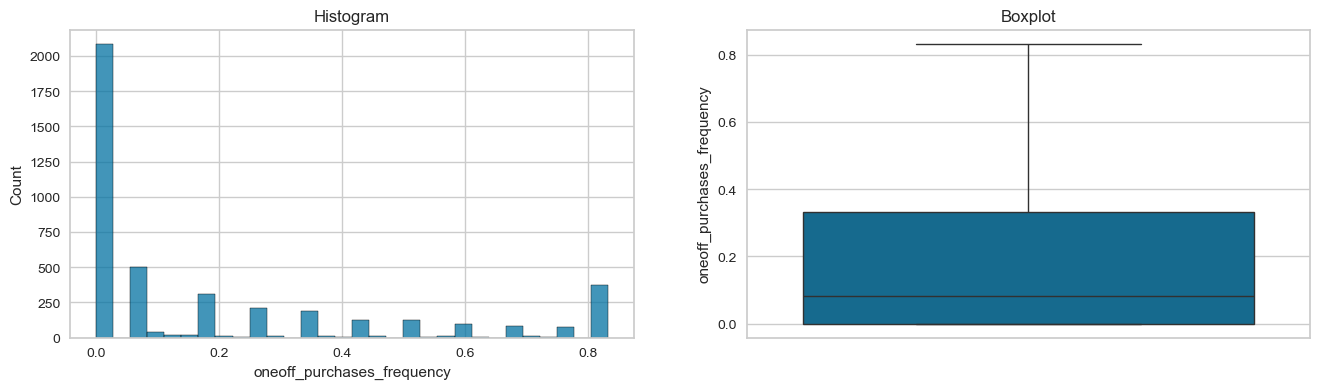

purchases_installments_frequency After Capping


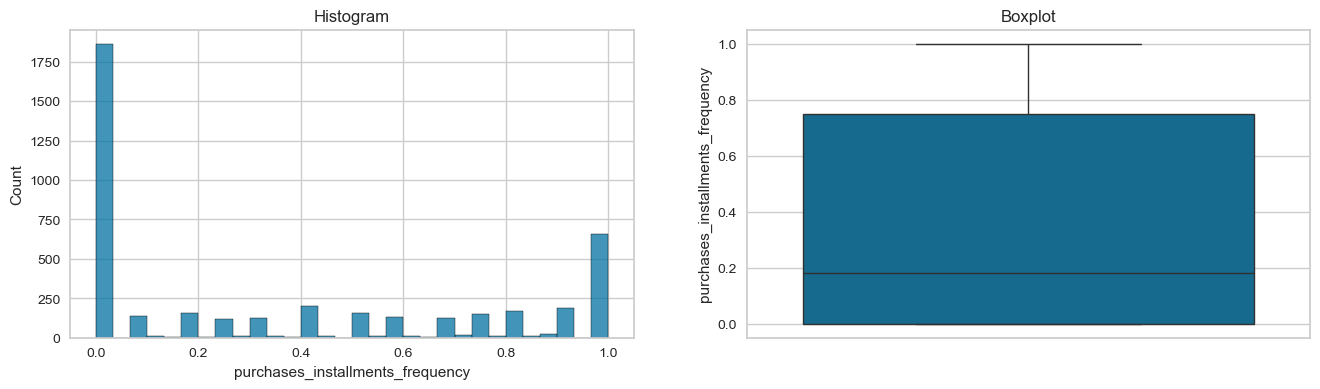

cash_advance_frequency After Capping


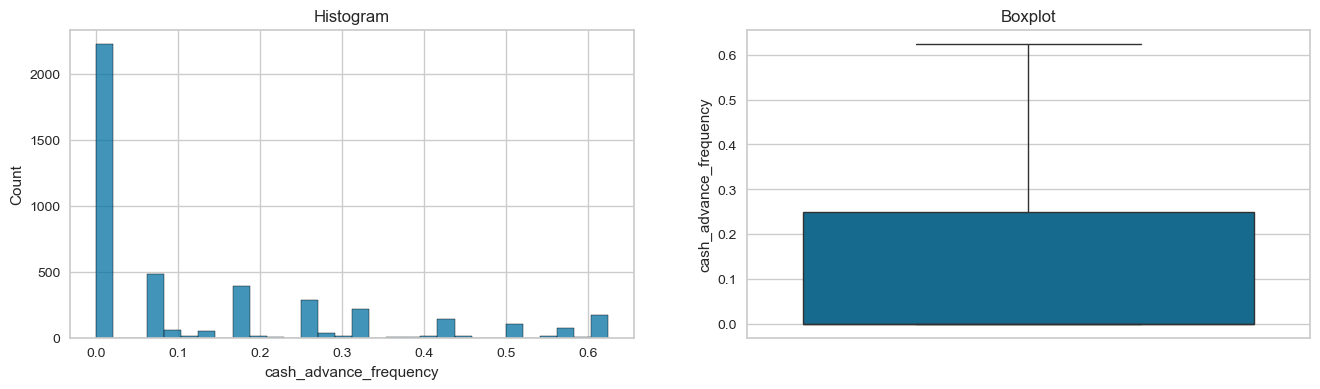

cash_advance_trx After Capping


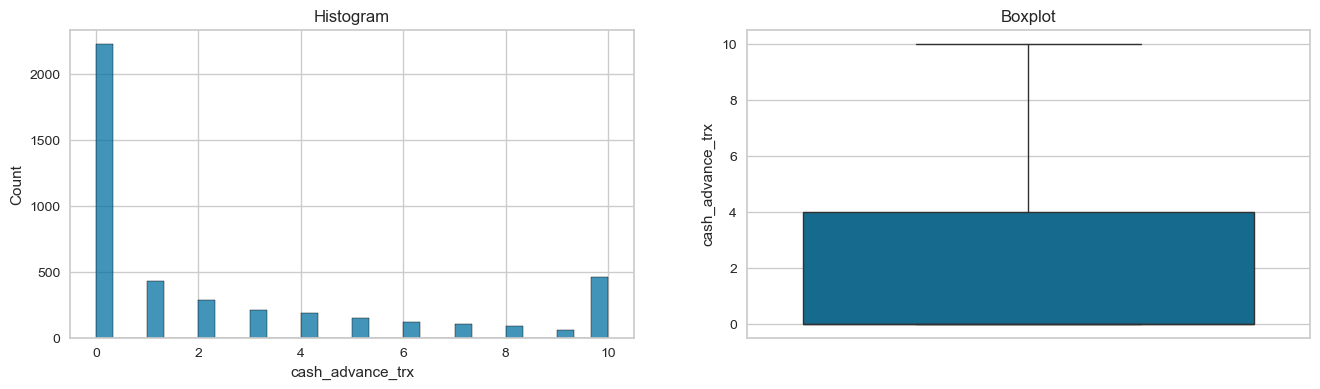

purchases_trx After Capping


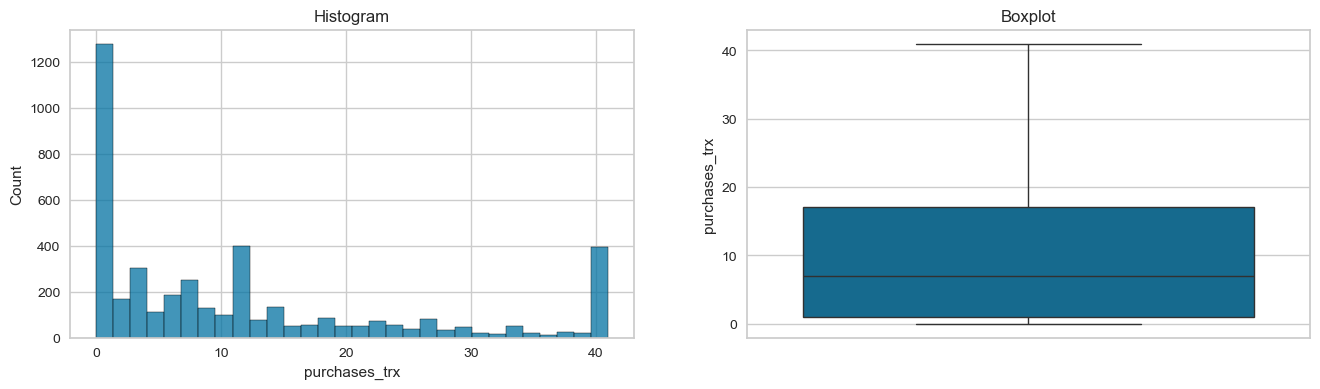

credit_limit After Capping


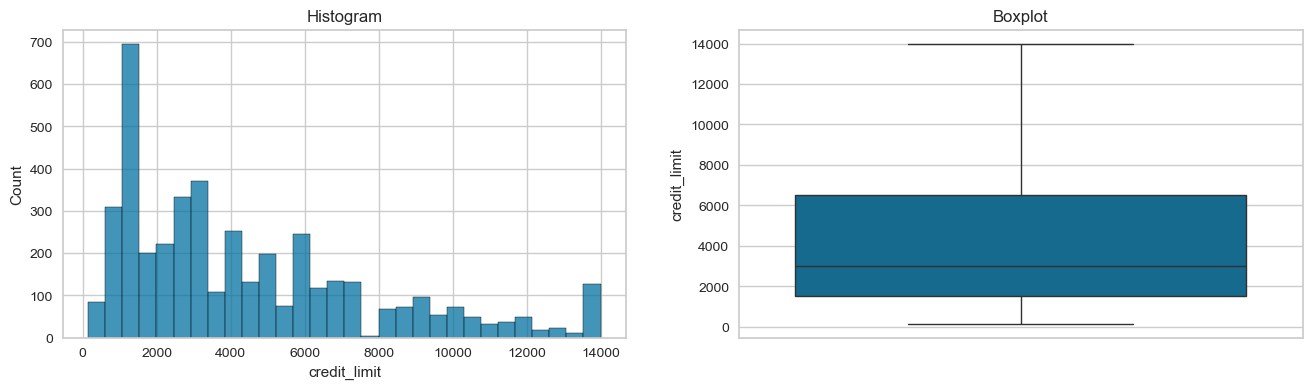

payments After Capping


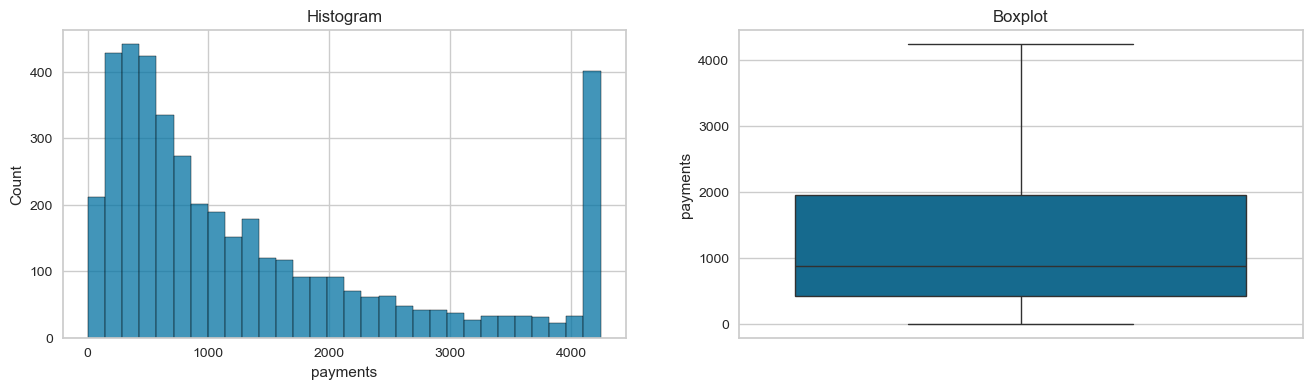

minimum_payments After Capping


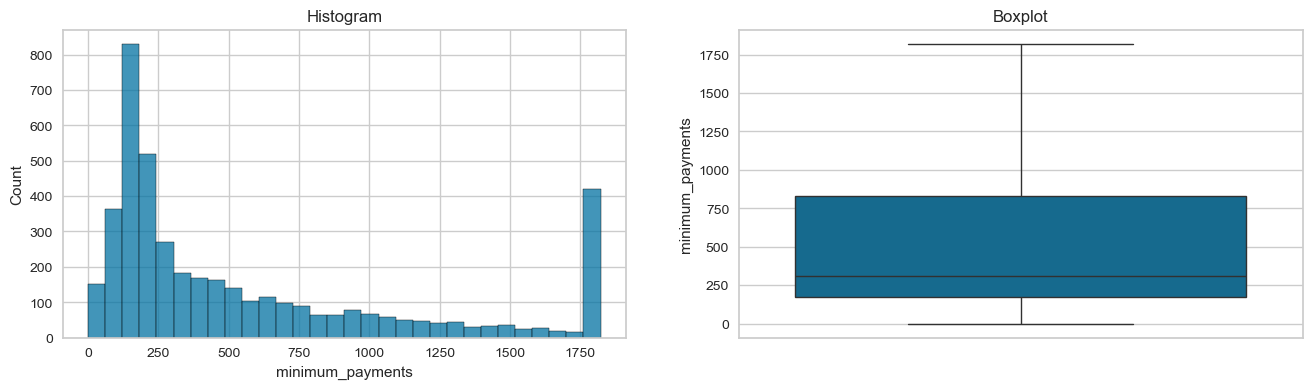

prc_full_payment After Capping


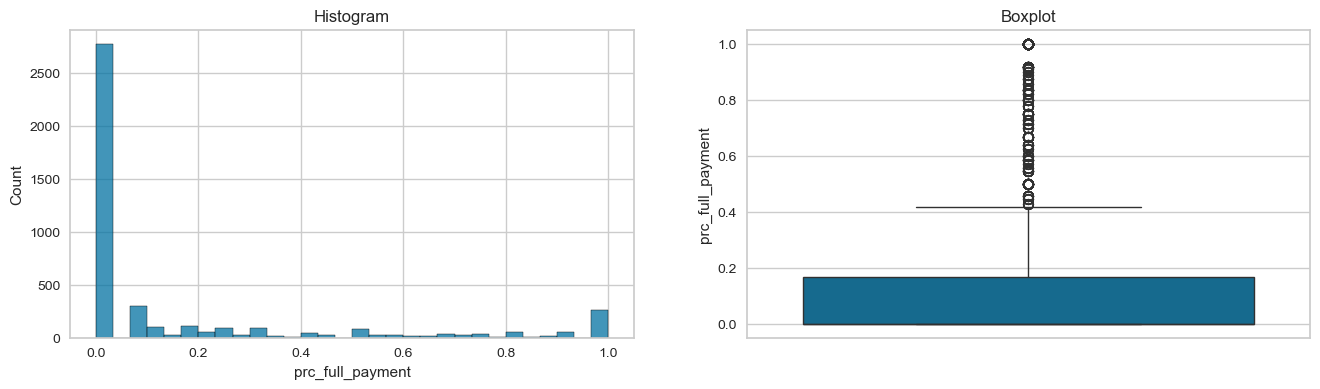

In [41]:
for column in columns_to_check:
    print(f'{column} After Capping')
    diagnostic_plots(df_handled, column)

## Feature Selection

In [42]:
df_handled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4316 entries, 1 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           4316 non-null   int64  
 1   balance                           4316 non-null   float64
 2   balance_frequency                 4316 non-null   float64
 3   purchases                         4316 non-null   float64
 4   oneoff_purchases                  4316 non-null   float64
 5   installments_purchases            4316 non-null   float64
 6   cash_advance                      4316 non-null   float64
 7   purchases_frequency               4316 non-null   float64
 8   oneoff_purchases_frequency        4316 non-null   float64
 9   purchases_installments_frequency  4316 non-null   float64
 10  cash_advance_frequency            4316 non-null   float64
 11  cash_advance_trx                  4316 non-null   int64  
 12  purchases_t

### Selection categorical data type 

__Dropping customer id__

cust_id feature is categorized as nominal categorical datatypes due the information of them were leading us to know that the label as one customer's characteristic

In [43]:
df_handled.drop(['cust_id'], axis=1, inplace=True)

### Selection numerical datatypes

- checking multicolinerity of the features

In [44]:
vif = pd.DataFrame()
vif["variables"] = df_handled.columns
vif["VIF"] = [variance_inflation_factor(df_handled, i) for i in range(df_handled.shape[1])]
vif

,variables,VIF
0,balance,10.052067
1,balance_frequency,24.367413
2,purchases,10.239641
3,oneoff_purchases,1.944793
4,installments_purchases,7.540778
5,cash_advance,2.572996
6,purchases_frequency,26.336571
7,oneoff_purchases_frequency,7.855520
8,purchases_installments_frequency,21.601967
9,cash_advance_frequency,11.008656


__Dropping features which has high value of multicolinearity and not considering to conduct analysis basis__

In [45]:
df_handled.drop(['balance_frequency','tenure'], 
        axis=1, inplace=True)

In [46]:
final_cols = df_handled.columns.tolist()
final_cols

['balance',
 'purchases',
 'oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'cash_advance_trx',
 'purchases_trx',
 'credit_limit',
 'payments',
 'minimum_payments',
 'prc_full_payment']

In [47]:
vif = pd.DataFrame()
vif["variables"] = df_handled.columns
vif["VIF"] = [variance_inflation_factor(df_handled, i) for i in range(df_handled.shape[1])]
vif

,variables,VIF
0,balance,9.560760
1,purchases,10.237164
2,oneoff_purchases,1.929185
3,installments_purchases,7.473369
4,cash_advance,2.438542
5,purchases_frequency,22.989493
6,oneoff_purchases_frequency,7.764864
7,purchases_installments_frequency,21.466464
8,cash_advance_frequency,10.568761
9,cash_advance_trx,11.304895


## Scalling

- conducting scaling the value of dataset in order to proceed the PCA process

In [48]:
# defining scaler method StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_handled)
df_scaled

array([[-0.31067429, -0.73106607, -0.29455442, ..., -0.91819027,
        -0.29220051, -0.5439301 ],
       [-0.62130015, -0.19570334, -0.00933212, ..., -0.88474481,
        -0.75768311, -0.5439301 ],
       [-0.23979655,  0.76506173,  0.50252948, ..., -0.77584489,
        -0.62197707, -0.5439301 ],
       ...,
       [ 1.26324289, -0.22238262, -0.10269804, ..., -0.27314849,
         0.56319886, -0.5439301 ],
       [ 2.20006194,  0.9271478 ,  0.5888832 , ..., -0.37742586,
         2.24637507, -0.24056163],
       [ 0.35514001,  0.30082893, -0.2212369 , ...,  1.30675057,
         0.60754992, -0.24056163]])

## PCA

Aiming to retain 95% of the data by performing PCA and reduce the dimensionality of the dataset

In [49]:
pca = PCA()
pca.fit(df_scaled)
pca

PCA()

# 7. Model Training

To determine the optimal number of principal components, using the elbow method based on eigenvalues. This method involves plotting the eigenvalues and selecting the number of principal components where the eigenvalues start to level off, indicating diminishing returns in explained variance beyond that point. This approach helps in finding a balance between reducing dimensionality and retaining a sufficient amount of information from the original dataset

## Elbow & Silhouette

In [50]:
df_scaled.shape

(4316, 15)

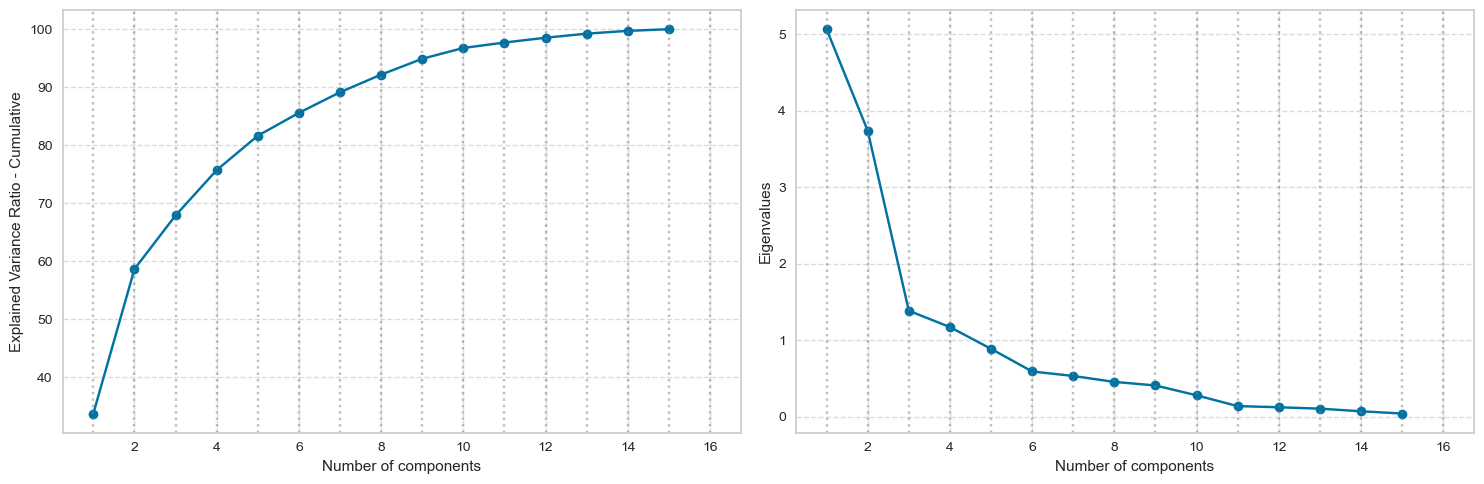

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Cumulative of Explained Variance Ratio
axes[0].plot(range(1, 16), np.cumsum(pca.explained_variance_ratio_ * 100), marker='o')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xlabel('Number of components')
axes[0].set_ylabel('Explained Variance Ratio - Cumulative')

# Menambahkan garis bayang vertikal pada subplot pertama
for i in range(1, 17):
    axes[0].axvline(x=i, linestyle=':', color='grey', alpha=0.5)

# Plot Eigenvalues
axes[1].plot(range(1, 16), pca.explained_variance_, marker='o')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('Eigenvalues')

# Menambahkan garis bayang vertikal pada subplot kedua
for i in range(1, 17):
    axes[1].axvline(x=i, linestyle=':', color='grey', alpha=0.5)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [52]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

10

Since I would like to retain 95% of the overall data variance, using 10 features based on the cumulative variance ratio calculation.

In [53]:
pca = PCA(n_components=num_features)
pca.fit(df_scaled)

df_scaled_pca = pca.transform(df_scaled)

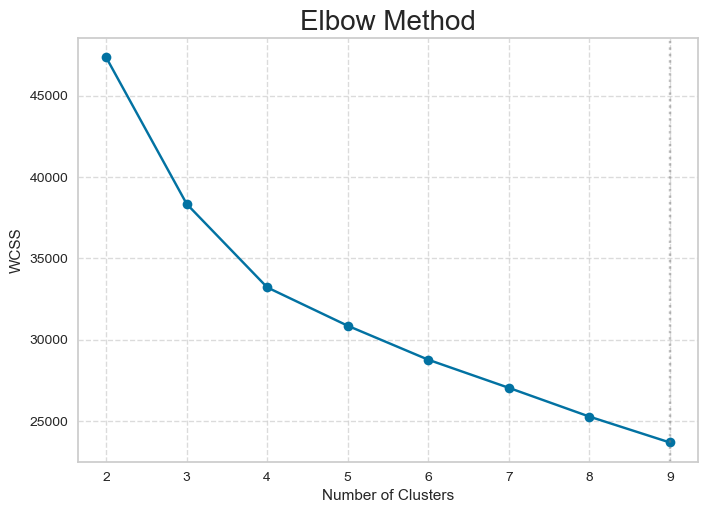

In [54]:
# Find the optimal number of clusters using Elbow Method
wcss = []
random_state = 12
max_cluster = 9


for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(df_scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=i, linestyle=':', color='grey', alpha=0.5)
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

From the elbow method visualization above, the 'elbow' point falls between 2 to 4. To further validate this, check the silhouette score.

In [55]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.25441344441670083
For n_clusters = 3 The average silhouette_score is : 0.2569371517222024
For n_clusters = 4 The average silhouette_score is : 0.23292201831786255
For n_clusters = 5 The average silhouette_score is : 0.194849531942302
For n_clusters = 6 The average silhouette_score is : 0.2082422265202101
For n_clusters = 7 The average silhouette_score is : 0.2109534927846807
For n_clusters = 8 The average silhouette_score is : 0.21453062047752627


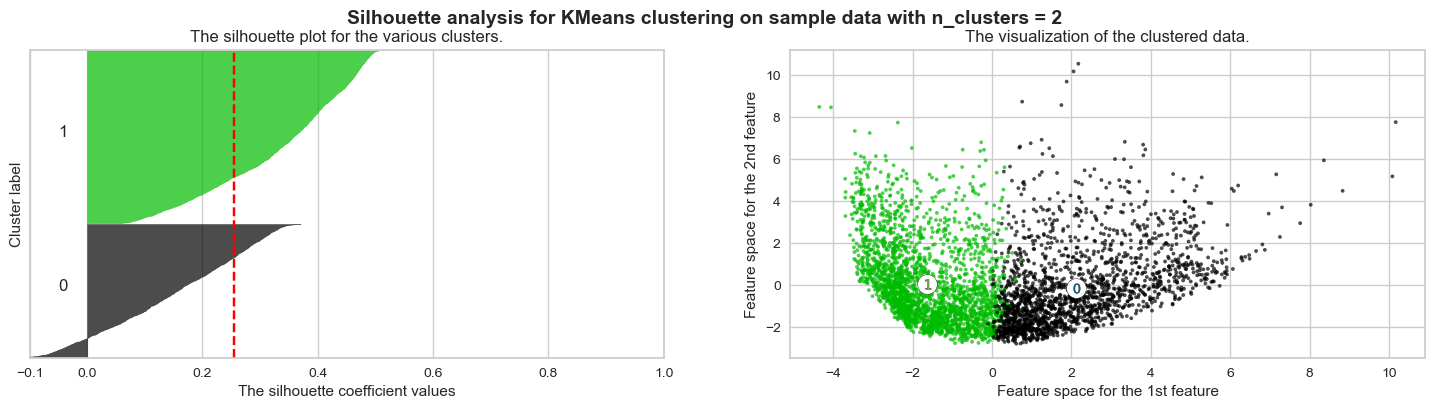

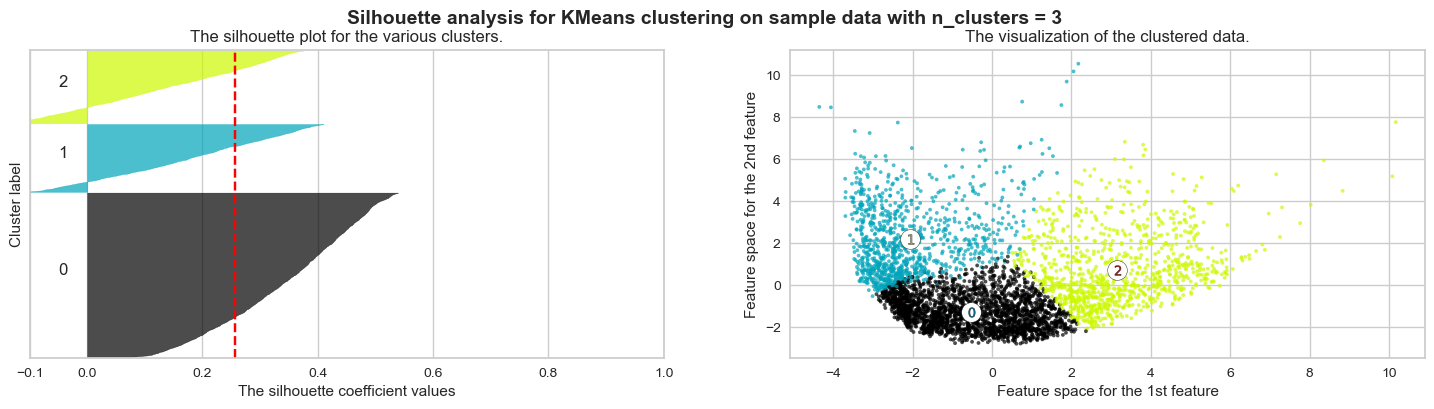

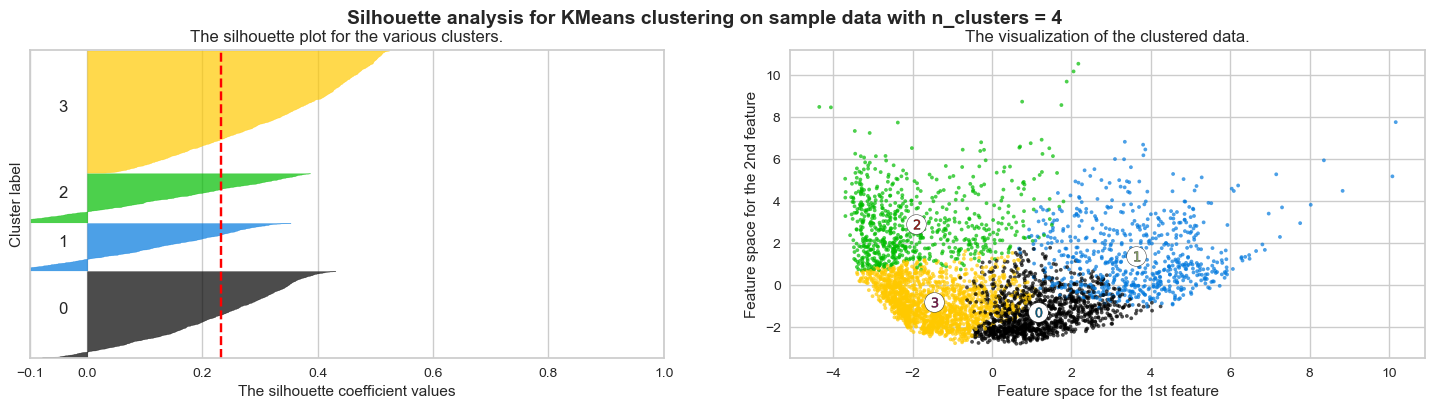

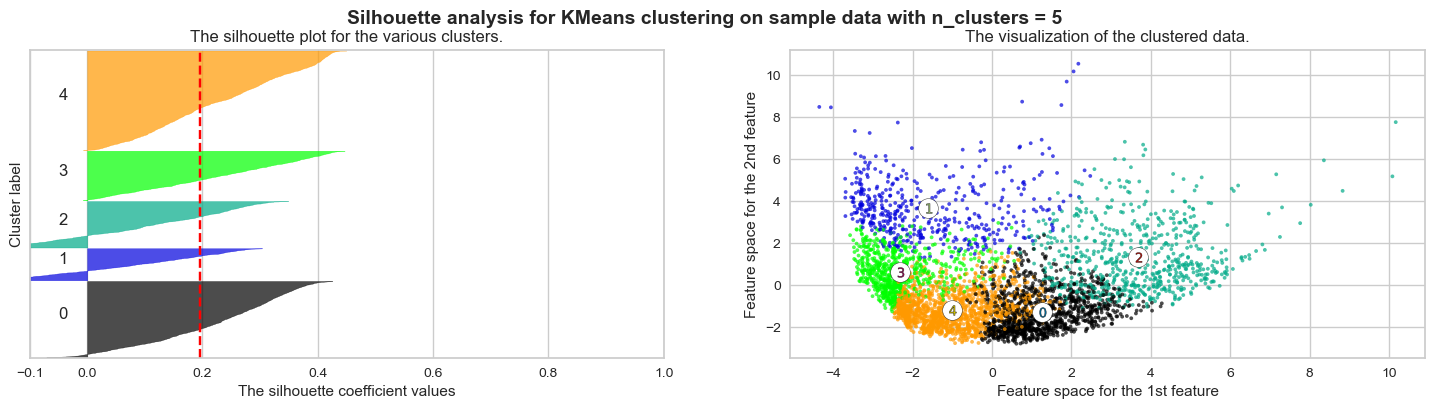

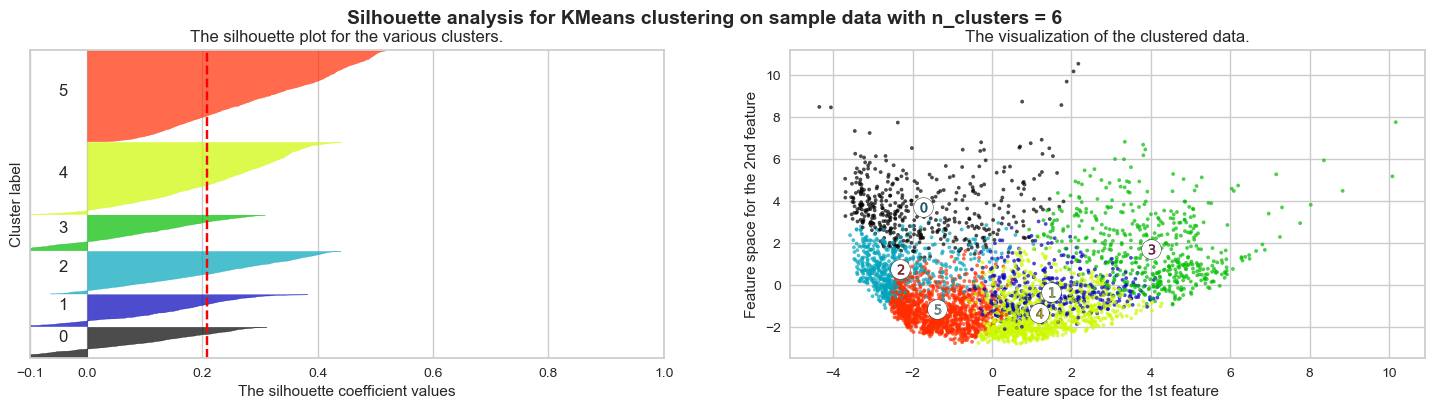

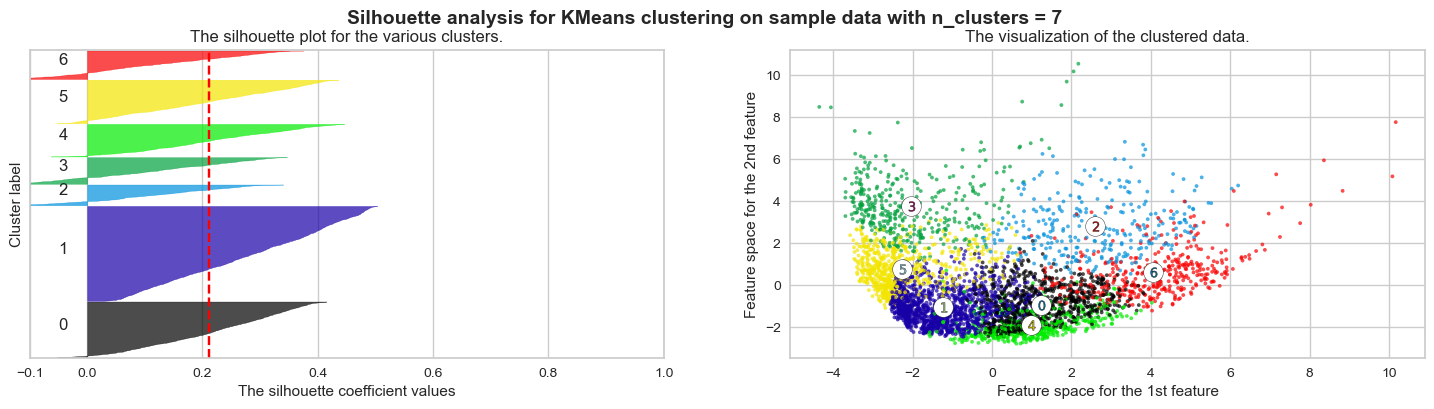

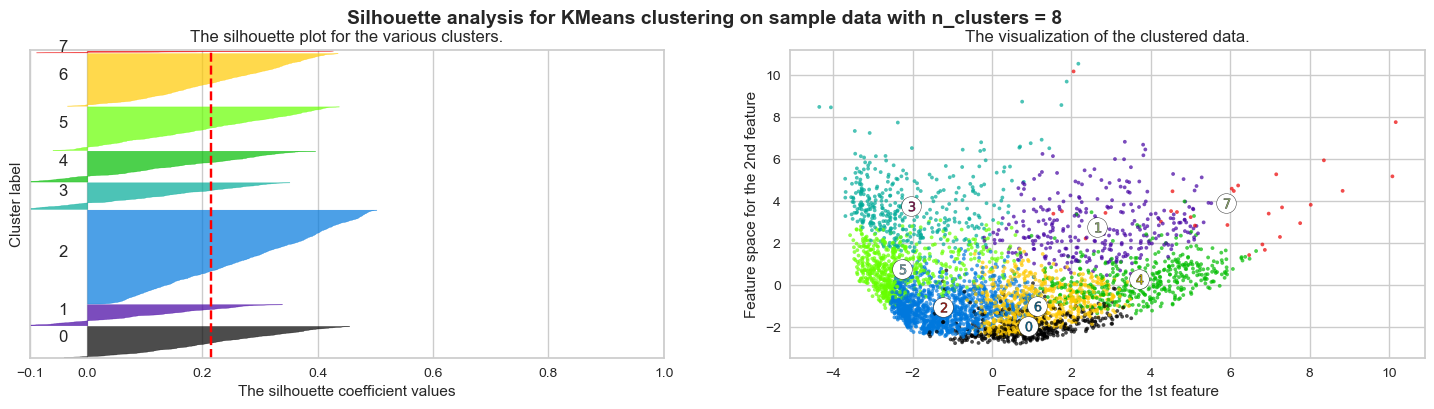

In [56]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), df_scaled_pca, random_state)

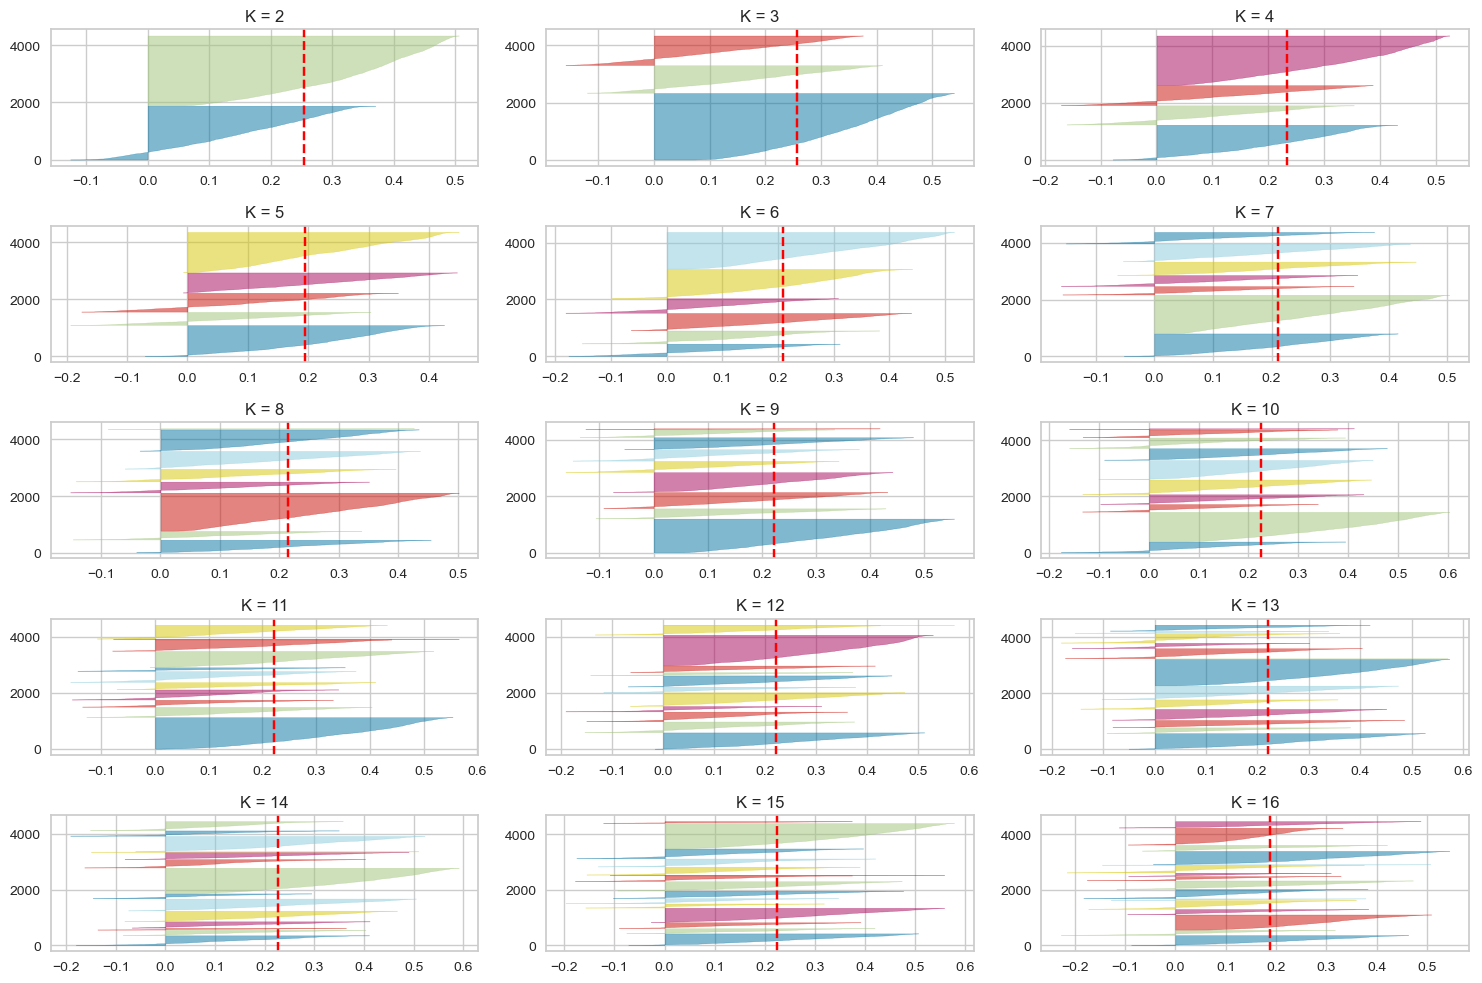

In [57]:
# Display the Silhouette Score and Plot Silhouette Plot
fig, axes = plt.subplots(5, 3, figsize=(15, 10))

# Loop for each plot
for i, ax in enumerate(axes.flatten()):

    # Initialize K-means clustering
    n_clusters = i + 2
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

    # Create SilhouetteVisualizer
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

    # Fit visualizer to data
    visualizer.fit(df_scaled_pca)

    # Set title
    ax.set_title(f'K = {n_clusters}')

# Adjust layout
plt.tight_layout()
plt.show()

# 8. Model Evaluation

The elbow method and inertia were considered during the clustering process. The elbow method helped identify the optimal number of clusters by analyzing the plot of inertia against the number of clusters. This method indicated that the inertia reduction slowed down significantly after reaching 4 clusters.

Considering the silhouette score results and the visualization of the cluster above, deciding to divide into 4 clusters. 

Good silhouette score, indicating relatively uniform data distribution across 3 out of 4 clusters. Although some them shows negative values (indicating mixed membership between clusters), these are within acceptable (reasonable) limits.

In [58]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = km.fit_predict(df_scaled_pca)
pred

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)

# 9. Exploratory Data Analysis After Clustering

### __Using the uncapped handled dataframe to provide information based on the exact number for each customer__

In [59]:
# create new dataframe with new column that define its cluster
df['cluster'] = pred
df

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cluster
1,1902,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,8,3
3,3426,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,8,3
4,3976,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,8,3
5,4266,2237.238086,1.000000,120.00,120.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,2500.0,343.102984,712.986387,0.000000,8,3
7,4680,424.994385,0.375000,1200.00,1200.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,1200.0,57.266292,56.720210,0.000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11,3
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11,2
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11,2
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11,2


In [60]:
df['cluster'].unique()

array([3, 1, 0, 2], dtype=int32)

### __The dataset is divided into 4 clusters: Value 0 represents Cluster 1, Value 1 represents Cluster 2, and so forth.__

## General average number of customer's metric (selected feature based on domain knowledge) 

In [61]:
general_number_cluster = df[['balance',
            'purchases',
            'cash_advance', 
            'credit_limit',
            'minimum_payments', 
            'payments',
            'cluster']].groupby('cluster').mean()
general_number_cluster

,balance,purchases,cash_advance,credit_limit,minimum_payments,payments
cluster,,,,,,
0,525.335810,782.360665,117.141413,3267.376391,572.159382,904.485896
1,2339.398503,4069.877064,465.197670,7845.650996,1058.443745,3948.777037
2,4254.878318,415.733046,4164.445089,6974.784483,1828.497790,3389.905764
3,1002.370600,261.080202,523.702402,3136.279607,582.794660,922.502676


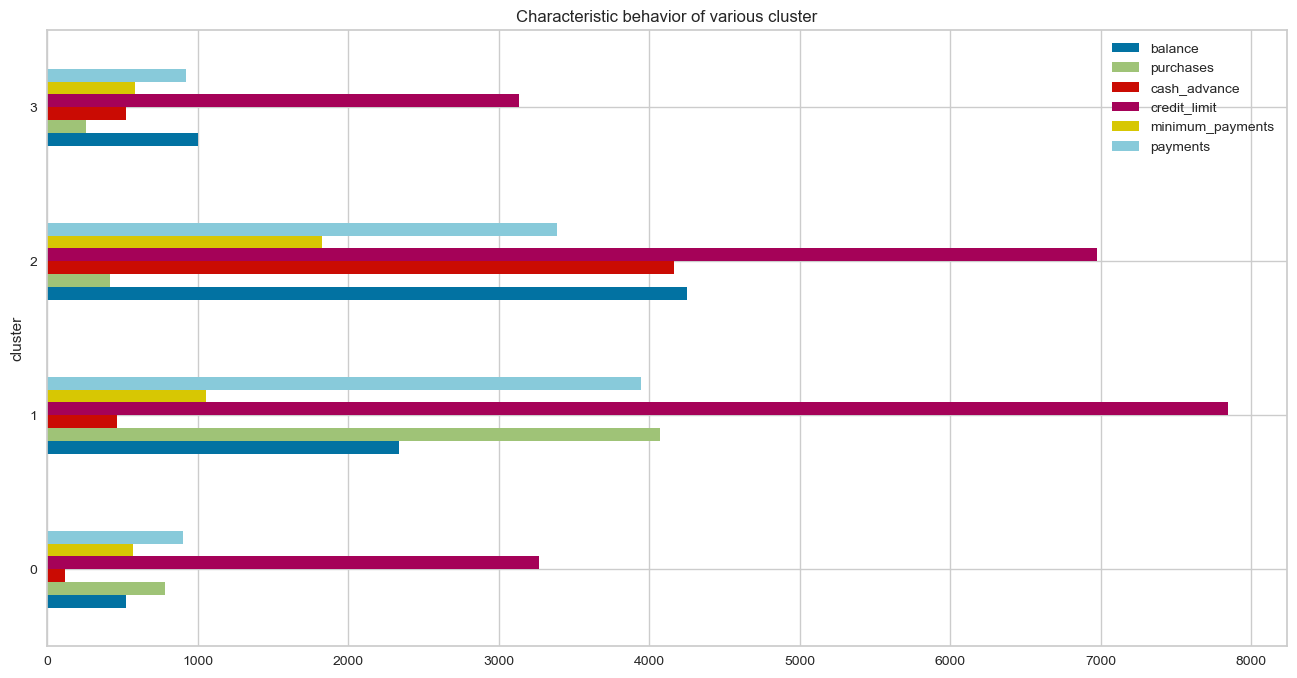

In [62]:
general_number_cluster.plot.barh(figsize=(16,8))
plt.title('Characteristic behavior of various cluster')
plt.show()

__Insights :__

- Cluster 1 represents customers with conservative financial behaviors and moderate spending across various categories.

- Customers in Cluster 2 have higher balances and make substantial purchases. They use cash advances moderately and have a significantly higher credit limit, suggesting higher spending capacity and possibly higher income or creditworthiness. The minimum payments and payments are also higher, reflecting proactive management of credit obligations.

- Cluster 3 relies significantly on cash advances, indicating specific financial strategies or needs, despite lower purchase amounts.

- Customers in Cluster 4 maintain lower balances and purchase amounts compared to other clusters. They use cash advances moderately and have a moderate credit limit. The minimum payments and payments are also moderate, indicating a balanced approach to financial management.

## Customer Activity Frequency on each cluster

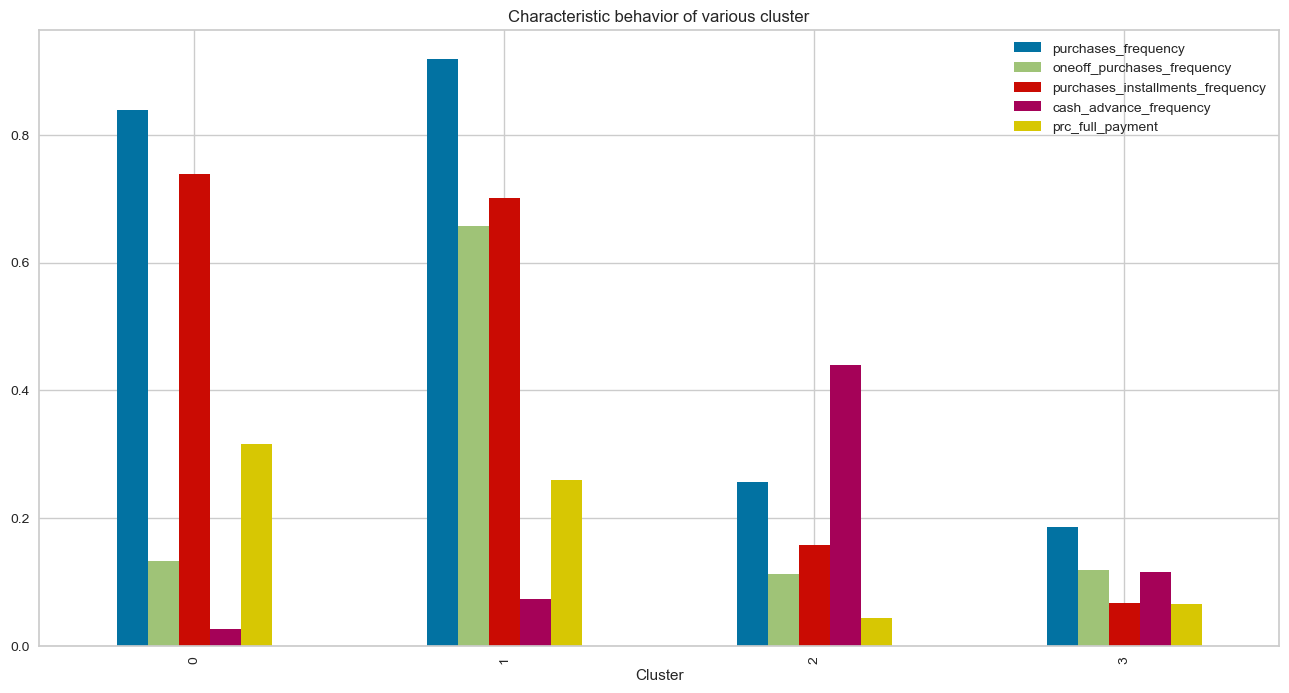

In [63]:
df[['purchases_frequency',
            'oneoff_purchases_frequency',
            'purchases_installments_frequency',
            'cash_advance_frequency',
            'prc_full_payment',
            'cluster']].groupby('cluster').mean().plot.bar(figsize=(16,8))
plt.title('Characteristic behavior of various cluster')
plt.xlabel('Cluster')
plt.show()

__Insight:__ 

- Cluster 1: Customers in this cluster make purchases frequently, with a preference for installment payments. They use installment purchases more than the other clusters.

- Cluster 2: This cluster consists of customers who generally have a high frequency of purchases, including both installment and one-off purchases. These customers are more active in their spending compared to those in other clusters.

- Cluster 3: Customers in this cluster frequently use cash advances. This group relies on cash advances more than any other cluster.

- Cluster 4: This cluster has customers who prefer one-off purchases over installment payments. They tend to make one-time purchases more often than installment-based ones.

## Distribution of credit limit on each cluster

### Initiate dataframe on each cluster

In [64]:
cluster_1 = df.loc[df['cluster'] == 0]
cluster_2 = df.loc[df['cluster'] == 1]
cluster_3 = df.loc[df['cluster'] == 2]
cluster_4 = df.loc[df['cluster'] == 3]

In [65]:
avg_limit_cluster_1 = cluster_1['credit_limit'].mean()
avg_limit_cluster_2 = cluster_2['credit_limit'].mean()
avg_limit_cluster_3 = cluster_3['credit_limit'].mean()
avg_limit_cluster_4 = cluster_4['credit_limit'].mean()

print(f'Average of credit limit on cluster 1: {avg_limit_cluster_1}')
print(f'Average of credit limit on cluster 2: {avg_limit_cluster_2}')
print(f'Average of credit limit on cluster 3: {avg_limit_cluster_3}')
print(f'Average of credit limit on cluster 4: {avg_limit_cluster_4}')

Average of credit limit on cluster 1: 3267.3763911691294
Average of credit limit on cluster 2: 7845.650995800298
Average of credit limit on cluster 3: 6974.7844827586205
Average of credit limit on cluster 4: 3136.2796071634893


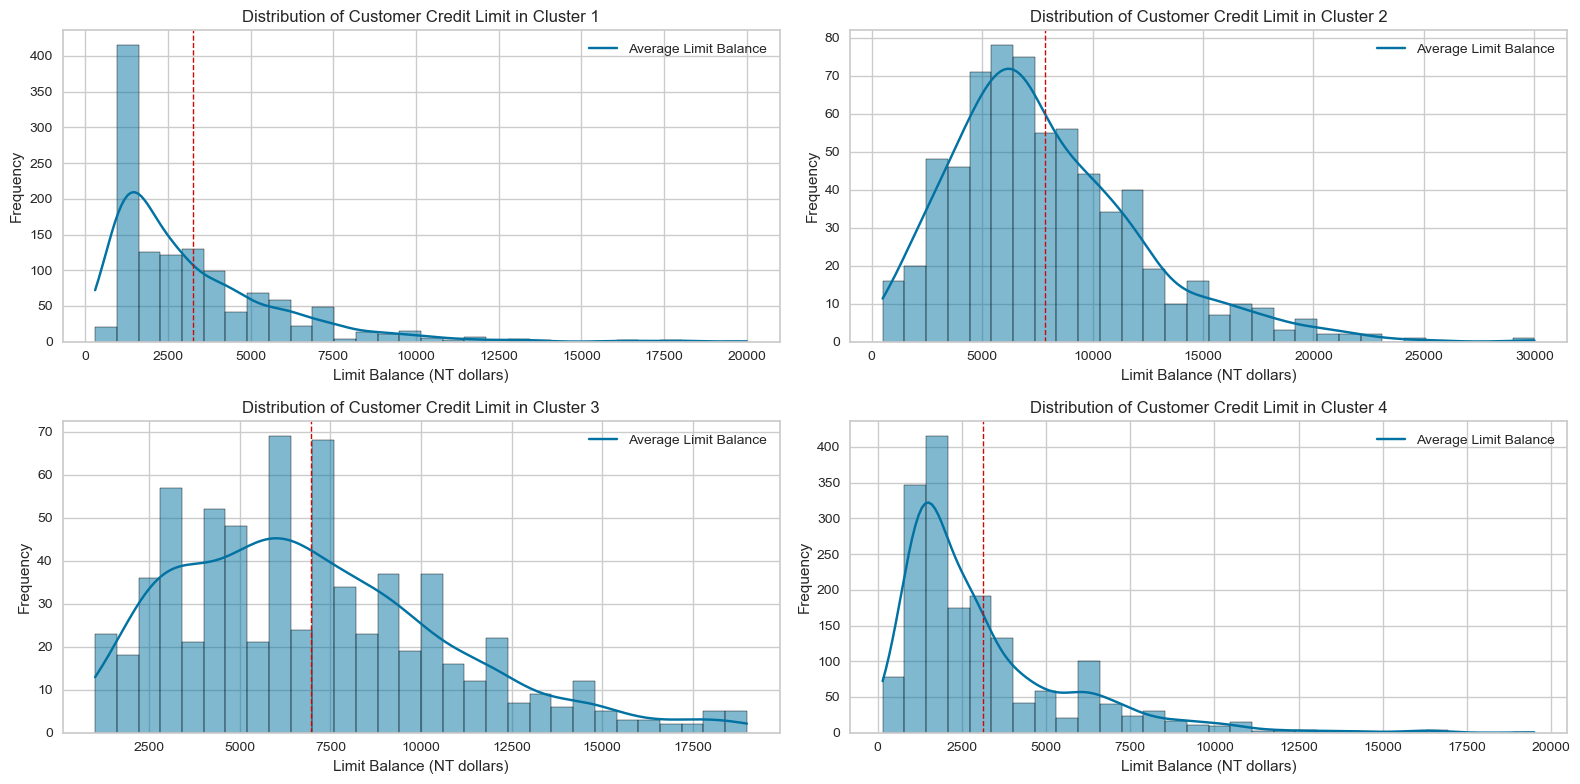

In [66]:
# Visualizing the distribution of limit balance with histogram 
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Plot for Cluster 1
sns.histplot(cluster_1['credit_limit'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].axvline(avg_limit_cluster_1, color='r', linestyle='dashed', linewidth=1)
axes[0, 0].set_title('Distribution of Customer Credit Limit in Cluster 1')
axes[0, 0].set_xlabel('Limit Balance (NT dollars)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend({'Average Limit Balance': avg_limit_cluster_1})

# Plot for Cluster 2
sns.histplot(cluster_2['credit_limit'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].axvline(avg_limit_cluster_2, color='r', linestyle='dashed', linewidth=1)
axes[0, 1].set_title('Distribution of Customer Credit Limit in Cluster 2')
axes[0, 1].set_xlabel('Limit Balance (NT dollars)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend({'Average Limit Balance': avg_limit_cluster_2})

# Plot for Cluster 3
sns.histplot(cluster_3['credit_limit'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].axvline(avg_limit_cluster_3, color='r', linestyle='dashed', linewidth=1)
axes[1, 0].set_title('Distribution of Customer Credit Limit in Cluster 3')
axes[1, 0].set_xlabel('Limit Balance (NT dollars)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend({'Average Limit Balance': avg_limit_cluster_3})

# Plot for Cluster 4
sns.histplot(cluster_4['credit_limit'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].axvline(avg_limit_cluster_4, color='r', linestyle='dashed', linewidth=1)
axes[1, 1].set_title('Distribution of Customer Credit Limit in Cluster 4')
axes[1, 1].set_xlabel('Limit Balance (NT dollars)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend({'Average Limit Balance': avg_limit_cluster_4})

plt.tight_layout()
plt.show()

__Insight :__

The average credit limits vary significantly across clusters, reflecting the different financial behaviors and profiles of customers in each group. Clusters with higher average credit limits (Cluster 2 and Cluster 3) show more active financial behaviors, either through frequent purchases or cash advances, while clusters with moderate credit limits (Cluster 1 and Cluster 4) exhibit more controlled spending patterns.

## Installment Purchasement Tendency in Each Cluster

In [67]:
installment_group = df[['installments_purchases','cluster']].groupby('cluster').count()
installment_group

,installments_purchases
cluster,
0,1218
1,671
2,696
3,1731


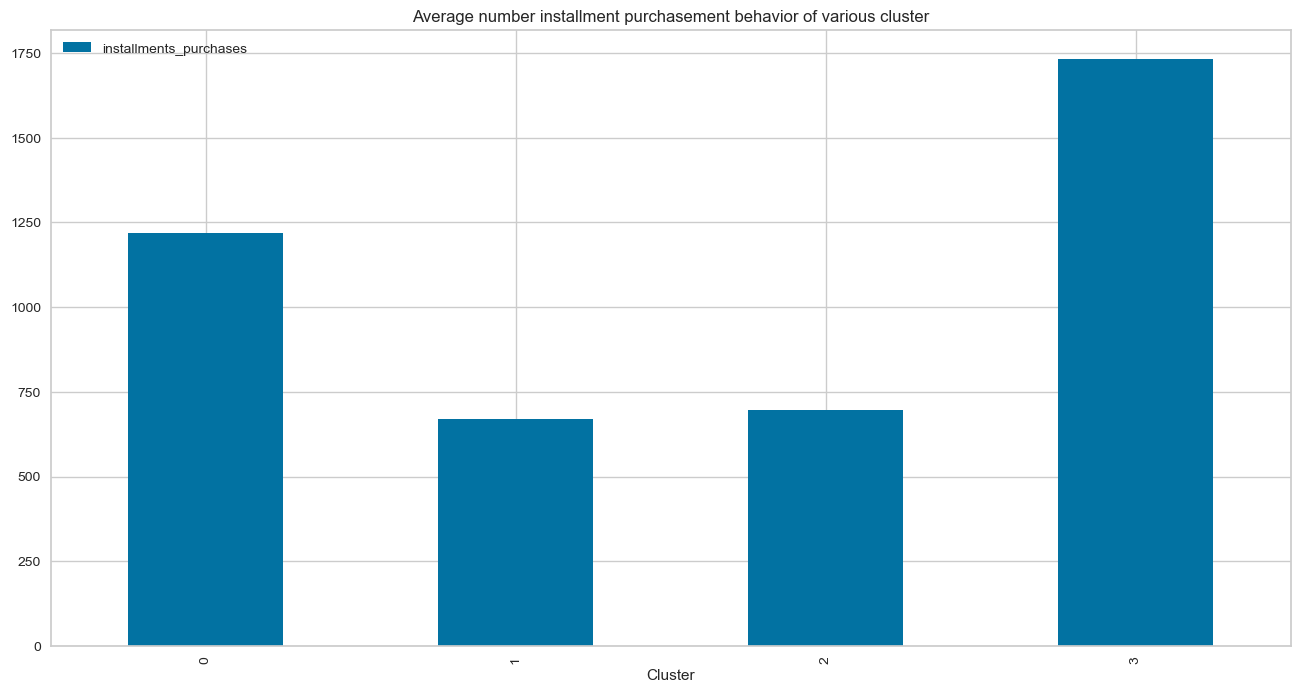

In [68]:
installment_group.plot.bar(figsize=(16,8))
plt.title('Average number installment purchasement behavior of various cluster')
plt.xlabel('Cluster')
plt.show()

__Insight:__

- Cluster 4 shows the highest tendency for installment purchases, followed by Cluster 1. 
- Clusters 2 and 3 have a lower but similar preference for installment payments. 
- Clusters 1 and 4 are more inclined to spread their payments over time, while Clusters 2 and 3 are less dependant on installment plans.

## Cash Advance Characteristic on each cluster

In [69]:
cluster_cash_advance = df[['cash_advance', 'cluster']].groupby('cluster').agg({'cash_advance': ['mean', 'count']})
cluster_cash_advance

cash_advance      
                mean count
cluster                   
0         117.141413  1218
1         465.197670   671
2        4164.445089   696
3         523.702402  1731

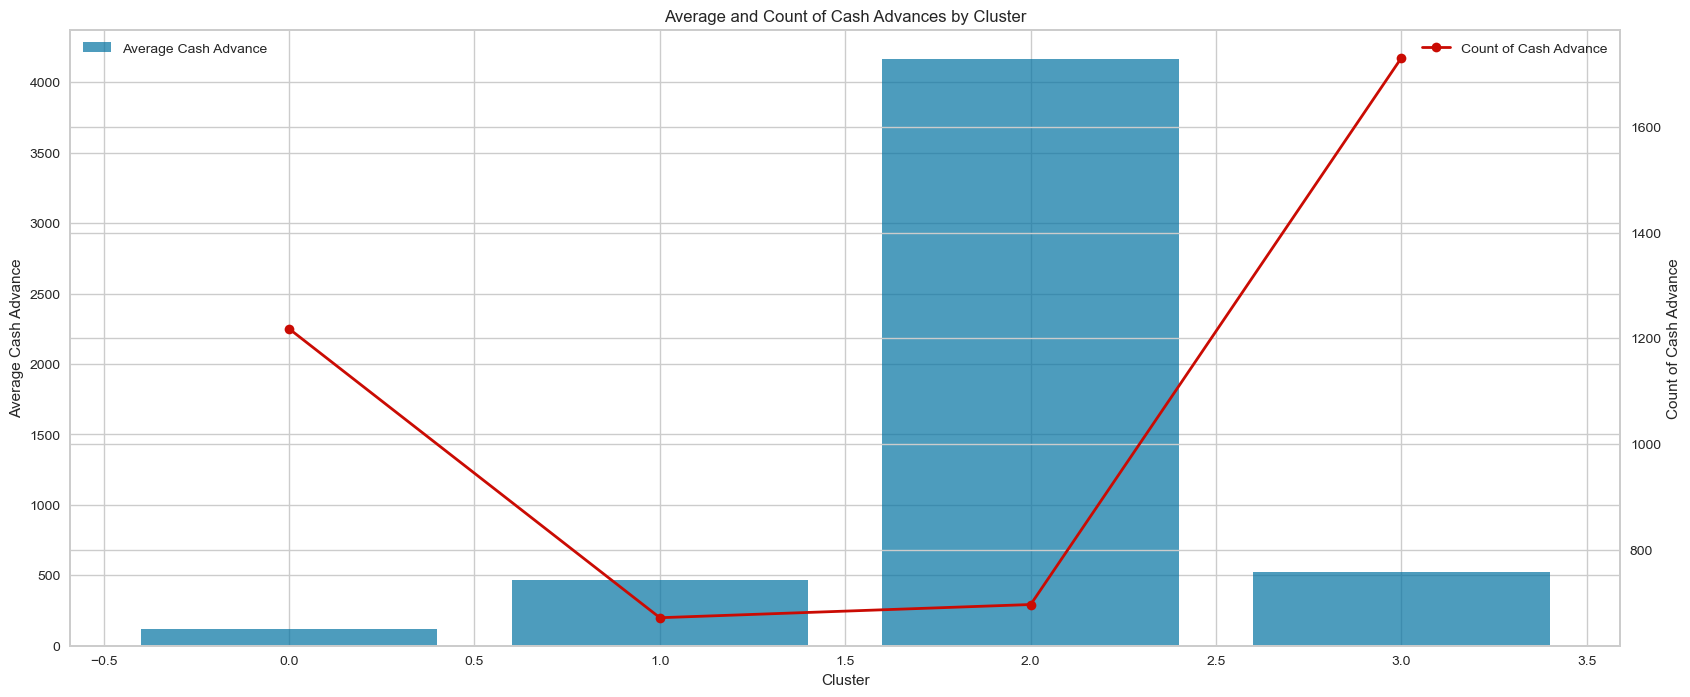

In [70]:
cluster_cash_advance.columns = ['average_cash_advance', 'count_cash_advance']

fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(cluster_cash_advance.index, cluster_cash_advance['average_cash_advance'], color='b', alpha=0.7, label='Average Cash Advance')
ax2 = ax1.twinx()
ax2.plot(cluster_cash_advance.index, cluster_cash_advance['count_cash_advance'], color='r', marker='o', linewidth=2, label='Count of Cash Advance')

ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average Cash Advance')
ax2.set_ylabel('Count of Cash Advance')
plt.title('Average and Count of Cash Advances by Cluster')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

__Insight:__

- Cluster 1: Customers in Cluster 1 have a relatively low average cash advance amount compared to other clusters. The cluster has "a considerable" number of instances where cash advances were used. This suggests a moderate use of cash advances among customers in this cluster.


- Cluster 2: Customers in Cluster 2 show a higher average cash advance amount compared to Cluster 1. Although the count of cash advances is lower than Cluster 1, the average amount indicates a higher individual transaction size for cash advances. This cluster might include customers who use cash advances less frequently but for larger amounts.


- Cluster 3: Cluster 3 exhibits a significantly higher average cash advance amount compared to all other clusters. The large average suggests that customers in this cluster heavily rely on cash advances for financial transactions. Despite a lower count compared to other clusters, the substantial average amount indicates significant financial reliance on cash advances.


- Cluster 4: Customers in Cluster 4 have a moderate average cash advance amount, similar to Cluster 2. However, this cluster has the highest count of cash advances among all clusters, indicating a high frequency of cash advance usage. Customers in this cluster may use cash advances more frequently for smaller amounts compared to Cluster 2.

- Cluster 1 and Cluster 2 show moderate usage of cash advances, but with some distinctions. Cluster 1 shows a higher average amount per transaction compared to Cluster 2. In contrast, Cluster 2 stands out with notably higher average cash advance amounts, indicating a stronger reliance on cash advances for financial needs. Meanwhile, Cluster 3 demonstrates a high frequency of cash advances, suggesting frequent utilization for smaller amounts compared to Cluster 2, although the total count remains significant. These insights highlight varying degrees of reliance on cash advances across different clusters, reflecting diverse financial behaviors and strategies among customers.

# 10. Model Saving

In [71]:
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(final_cols, file_1)

with open('scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('pca.pkl', 'wb') as file_3:
  pickle.dump(pca, file_3)

with open('model_km.pkl', 'wb') as file_4:
  pickle.dump(km, file_4)


# 11. Conclusion

## Overall (in general) Data Conclusion

- The majority of customers update their balance frequently (Frequently), with 3613 customers, indicating active monitoring of their financial status.

- The smallest group comprises 37 customers who never update their balance. This suggests either inactive account usage or alternative methods for financial tracking.

- Most customers (3727 entries) have a high credit risk, while a smaller number (748 entries) exhibit lower credit risk.

- The percentage of bank funds received (87.33%) indicates a predominant inflow of funds into the bank. This suggests that the bank is largely engaged in activities involving regular payments from customers or other sources of income such as interest or penalties.

- Given that the majority of customers have high credit risk, the bank needs to enhance its risk management strategies to mitigate potential losses. This includes increasing proactive credit monitoring, conducting stricter evaluations of high-risk customers, and developing effective credit recovery solutions.

## Cluster Conclusion

- Cluster 1: Shows conservative financial behavior with moderate spending. They tend to prefer installment purchases compared to other clusters.

- Cluster 2: Cluster 2 Has higher balances and substantial purchase activity. Moderate use of cash advances with a significant credit limit indicates high spending capacity, possibly higher income or creditworthiness. Higher minimum payments and payments reflect proactive credit management.

- Cluster 3: Relies significantly on cash advances, indicating specific financial strategies or needs despite lower purchase amounts.

- Cluster 4: Shows lower balances and purchase amounts compared to other clusters. Moderate use of cash advances with a moderate credit limit reflects a balanced approach to financial management.

*Cluster 1 and Cluster 4 demonstrate conservative spending habits, preferring moderate use of cash advances. They manage their finances cautiously, possibly opting for installment payments over large one-time purchases. In contrast, Cluster 2 engages in more active financial behavior, utilizing cash advances extensively and maintaining a high credit limit. This cluster likely includes individuals who are comfortable managing higher levels of debt and expenses. On the other hand, Cluster 3 relies heavily on cash advances for financial transactions, indicating specific financial strategies or immediate financial needs. The average amounts involved suggest frequent reliance on cash advances for smaller but regular expenses. These insights into each cluster's financial behaviors provide a nuanced understanding of their spending patterns and financial strategies.*